<a href="https://colab.research.google.com/github/tammyliuu/Pricing-Theory/blob/main/pricing_project1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
def build_stock_tree(S0, u, d, N):
    """
    Build a binomial stock price tree.

    Parameters:
    S0 : float : Initial stock price
    u : float : Up factor
    d : float : Down factor
    N : int : Number of time steps

    Returns:
    numpy.ndarray : Stock price tree
    """
    stock_tree = np.zeros((N + 1, N + 1))
    stock_tree[0, 0] = S0
    for i in range(1, N + 1):
        for j in range(i + 1):
            if j == 0:
                stock_tree[i, j] = stock_tree[i - 1, j] * d * np.exp(r * delta_t)
            else:
                stock_tree[i, j] = stock_tree[i - 1, j - 1] * u * np.exp(r * delta_t)
    return stock_tree


def build_option_tree(stock_tree, K, r, q, delta_t, N):
    """
    Build a binomial option value tree for an American put option.

    Parameters:
    stock_tree : numpy.ndarray : Stock price tree
    K : float : Strike price
    r : float : Risk-free rate
    q : float : Risk-neutral probability
    delta_t : float : Time step size
    N : int : Number of time steps

    Returns:
    numpy.ndarray : Option value tree
    """
    discount_factor = np.exp(-r * delta_t)
    option_tree = np.zeros((N + 1, N + 1))
    # Initialize option values at maturity
    for j in range(N + 1):
        option_tree[N, j] = max(K - stock_tree[N, j], 0)
    # Perform backward induction to calculate option value
    for i in range(N - 1, -1, -1):
        for j in range(i + 1):
            hold_value = discount_factor * (q * option_tree[i + 1, j + 1] + (1 - q) * option_tree[i + 1, j])
            exercise_value = max(K - stock_tree[i, j], 0)
            option_tree[i, j] = max(hold_value, exercise_value)
    return option_tree

def determine_exercise_boundary(stock_tree, option_tree, K, r, q, delta_t, N):
    """
    Determine the exercise boundary for an American put option.

    Parameters:
    stock_tree : numpy.ndarray : Stock price tree
    option_tree : numpy.ndarray : Option value tree
    K : float : Strike price
    r : float : Risk-free rate
    q : float : Risk-neutral probability
    delta_t : float : Time step size
    N : int : Number of time steps

    Returns:
    list : List of tuples representing the exercise boundary (time, stock price)
    """
    discount_factor = np.exp(-r * delta_t)
    exercise_boundary = []

    for i in range(N):
        max_stock_price_for_exercise = None
        for j in range(i + 1):
            hold_value = discount_factor * (q * option_tree[i + 1, j + 1] + (1 - q) * option_tree[i + 1, j])
            exercise_value = max(K - stock_tree[i, j], 0)

            if exercise_value > hold_value:
                if max_stock_price_for_exercise is None or stock_tree[i, j] > max_stock_price_for_exercise:
                    max_stock_price_for_exercise = stock_tree[i, j]

        if max_stock_price_for_exercise is not None:
            exercise_boundary.append((i * delta_t, max_stock_price_for_exercise))

    return exercise_boundary

def calculate_delta(option_tree, stock_tree, N):
    delta = np.zeros((N, N))  # Store delta for each time step
    for i in range(N):
        for j in range(i + 1):
            delta_value = (option_tree[i + 1, j + 1] - option_tree[i + 1, j]) / (stock_tree[i + 1, j + 1] - stock_tree[i + 1, j])
            delta[i, j] = delta_value
            # Print delta values for each node to observe trends
            # print(f"Delta at time {i} and node {j}: {delta_value}")
    return delta

# Get hedging strategy along a specific path
def get_hedging_strategy(path, delta_tree, N):
    hedge_strat = []
    node = 0  # Start at the root of the tree
    for i in range(N):
        hedge_strat.append(delta_tree[i, node])
        if path[i + 1] > path[i]:  # If the stock price went up
            node = node +1  # move to next column up
        else:  # If the stock price went down
            node = node  # stay same column
    return hedge_strat

### 1.a) risk netural measure


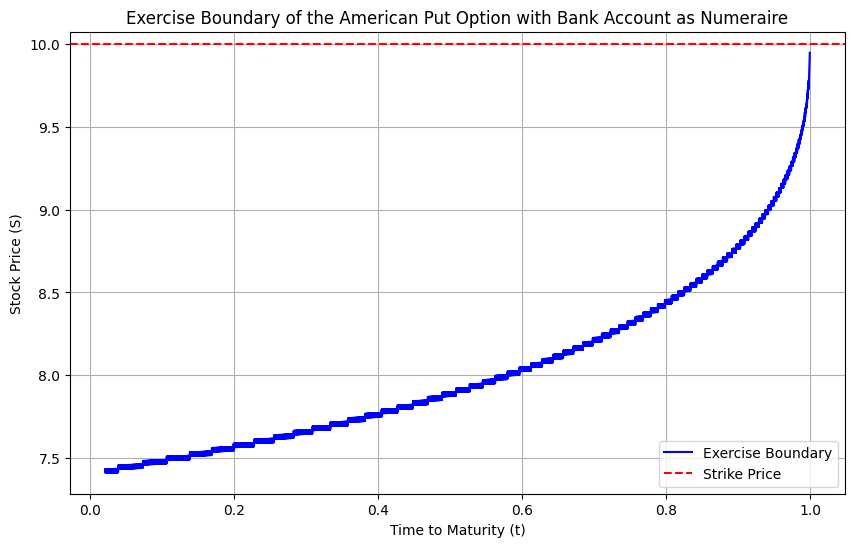

The initial price of the American put option is: $0.7111


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(63)
# Input parameters
T = 1  # time to maturity
S0 = 10  # initial stock price
sigma = 0.20  # volatility
r = 0.02  # risk-free rate
N = 5000  # number of time steps
K = 10  # strike price

# Calculate delta t
delta_t = T / N

# Calculate up and down factors
u = np.exp(sigma * np.sqrt(delta_t))
d = 1/u

q = (1-np.exp(-sigma * np.sqrt(delta_t)))/(np.exp(sigma * np.sqrt(delta_t))-np.exp(-1*sigma * np.sqrt(delta_t)))  # risk-neutral probability of up move

# Discount factor for each step
discount_factor = np.exp(-r * delta_t)

# Step 1: Build the stock price tree
stock_tree = build_stock_tree(S0, u, d, N)

# Step 2: Build the option value tree
option_tree = build_option_tree(stock_tree, K, r, q, delta_t, N)

exercise_boundary = []
exercise_boundary = determine_exercise_boundary(stock_tree, option_tree, K, r, q, delta_t, N)

# Reverse the list to plot from t=0 to T
exercise_boundary = list(reversed(exercise_boundary))

if exercise_boundary:
    times1, boundary_prices = zip(*exercise_boundary)  # Unzip times and stock prices for plotting

plt.figure(figsize=(10, 6))
plt.plot(times1, boundary_prices, label='Exercise Boundary', color='blue')
plt.axhline(y=K, color='red', linestyle='--', label='Strike Price')
plt.xlabel("Time to Maturity (t)")
plt.ylabel("Stock Price (S)")
plt.title("Exercise Boundary of the American Put Option with Bank Account as Numeraire")
plt.legend()
plt.grid(True)
plt.show()

# Initial option price at t=0 is the option value at the root node
initial_option_price = option_tree[0,0]
print(f"The initial price of the American put option is: ${initial_option_price:.4f}")


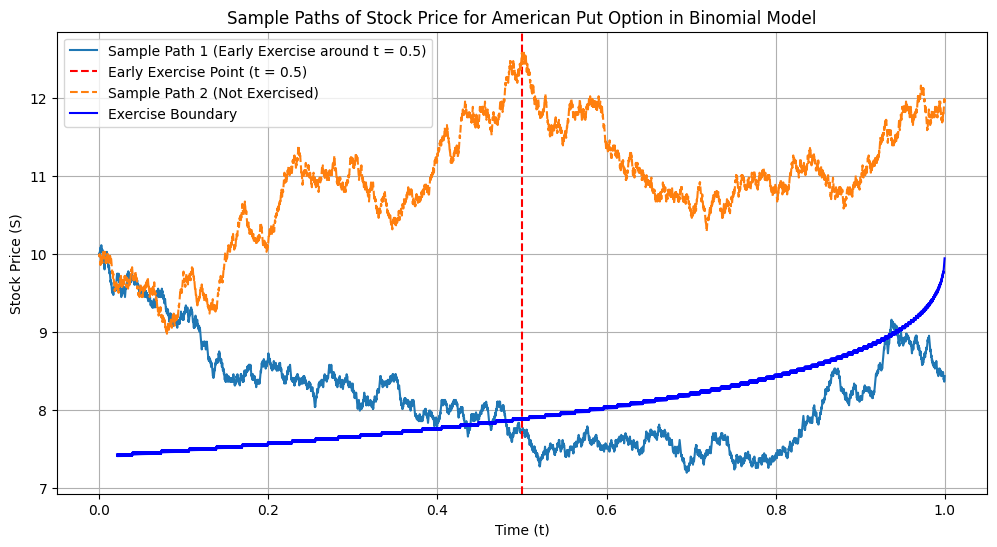

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
np.random.seed(63)
## Input parameters
T = 1  # time to maturity
S0 = 10  # initial stock price
sigma = 0.20  # volatility
r = 0.02  # risk-free rate
N = 5000  # number of time steps
K = 10  # strike price
delta_t = T / N
mu = 0.05

# Calculate up and down factors
u = np.exp(r*delta_t + sigma * np.sqrt(delta_t))
d = 1/u
p = 0.5*(1+((mu-r)-0.5*sigma**2)/sigma*np.sqrt(delta_t))

# Path 1: Exercise at t = 0.5
path1 = [S0]
for i in range(N):
        path1.append(path1[-1] * (u if np.random.rand() < p else d))

# Path 2: No early exercise
path2 = [S0]
for i in range(N):
    path2.append(path2[-1] * (u if np.random.rand() < p else d))

# Generate times array for plotting
times = np.linspace(0, T, N + 1)

# Plot the sample paths
plt.figure(figsize=(12, 6))

# Plot path 1 (early exercise)
plt.plot(times, path1, label="Sample Path 1 (Early Exercise around t = 0.5)")
plt.axvline(x=0.5, color='red', linestyle='--', label="Early Exercise Point (t = 0.5)")

# Plot path 2 (not exercised)
plt.plot(times, path2, label="Sample Path 2 (Not Exercised)", linestyle='--')

plt.plot(times1, boundary_prices, label='Exercise Boundary', color='blue')

# Labels and title
plt.xlabel('Time (t)')
plt.ylabel('Stock Price (S)')
plt.title('Sample Paths of Stock Price for American Put Option in Binomial Model')
plt.legend()
plt.grid(True)
plt.show()

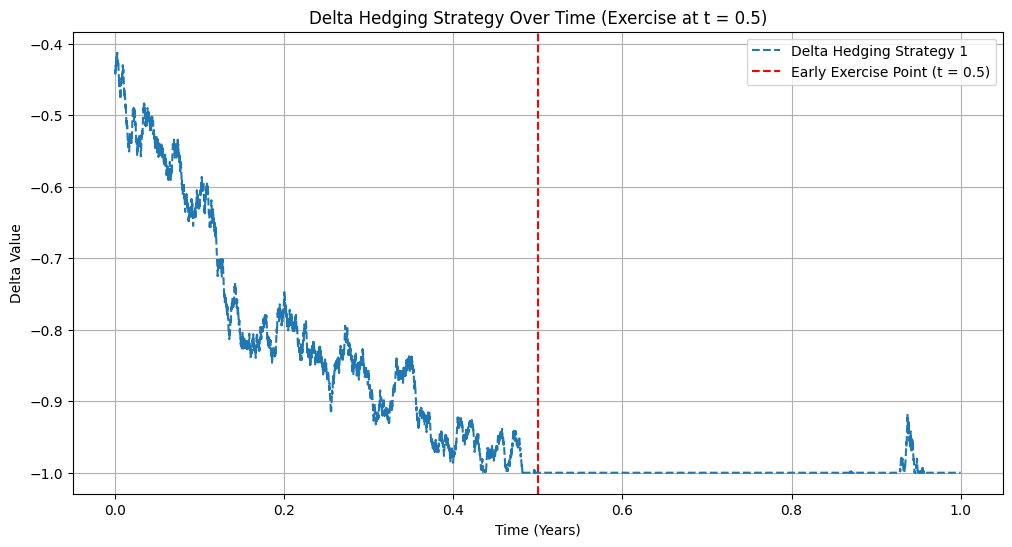

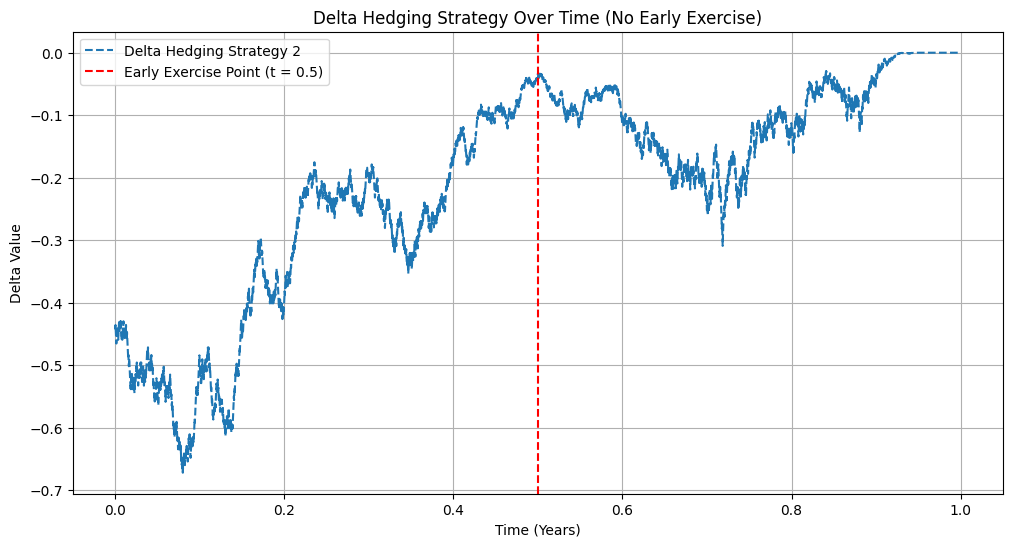

In [ ]:

np.random.seed(63)
# Generate stock price tree and option price tree
S = stock_tree
V = option_tree
N = 5000  # number of time steps
K = 10  # strike price
# Calculate delta values
delta_tree = calculate_delta(V, S, N)

# Get hedging strategies along the paths
hedging_strategy1 = get_hedging_strategy(path1, delta_tree, N)
hedging_strategy2 = get_hedging_strategy(path2, delta_tree, N)

# Plot hedging strategies
plt.figure(figsize=(12, 6))
plt.plot(np.linspace(0, T, N), hedging_strategy1, label="Delta Hedging Strategy 1", linestyle='--')
plt.axvline(x=0.5, color='red', linestyle='--', label="Early Exercise Point (t = 0.5)")
plt.xlabel('Time (Years)')
plt.ylabel('Delta Value')
plt.title('Delta Hedging Strategy Over Time (Exercise at t = 0.5)')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(np.linspace(0, T, N), hedging_strategy2, label="Delta Hedging Strategy 2", linestyle='--')
plt.axvline(x=0.5, color='red', linestyle='--', label="Early Exercise Point (t = 0.5)")
plt.xlabel('Time (Years)')
plt.ylabel('Delta Value')
plt.title('Delta Hedging Strategy Over Time (No Early Exercise)')
plt.legend()
plt.grid(True)
plt.show()


# iiii)

boundary editing

vo=0.2, r = 0.02

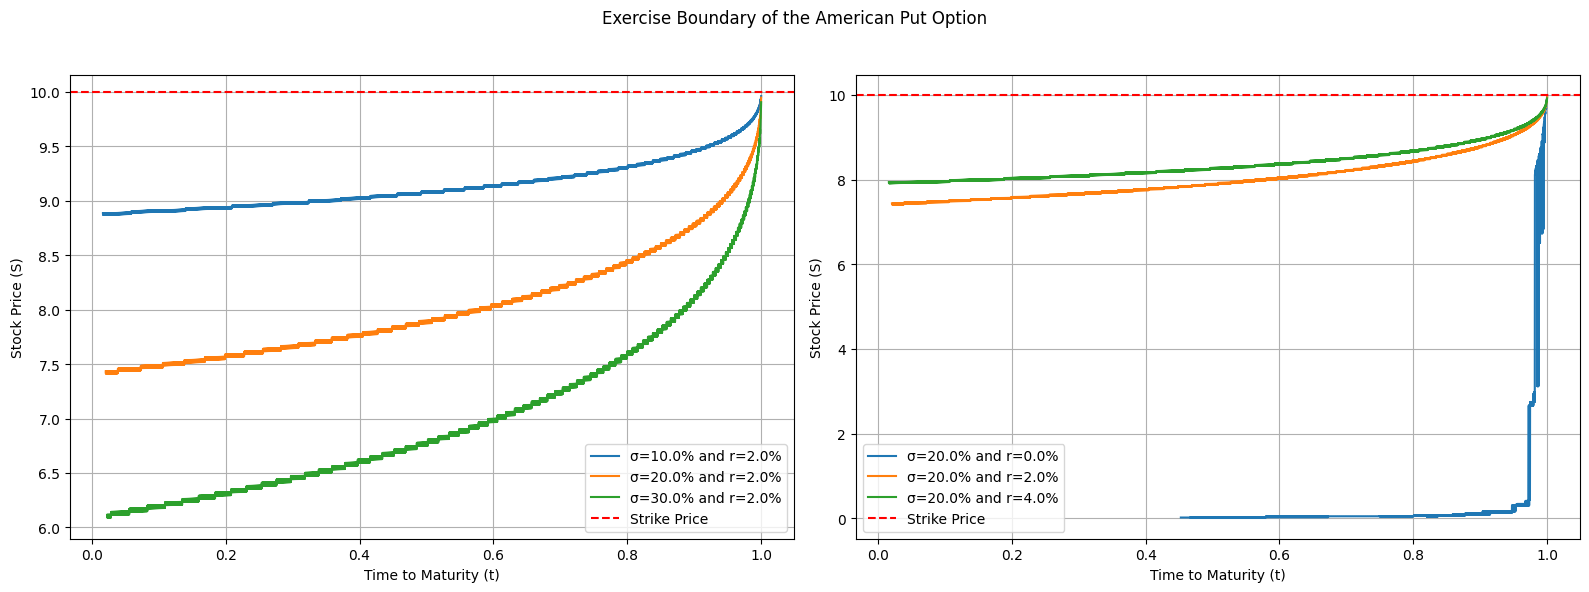

In [ ]:
np.random.seed(63)
# Input parameters
T = 1  # time to maturity
S0 = 10  # initial stock price
N = 5000  # number of time steps
K = 10  # strike price
delta_t = T / N

# Volatility and risk-free rate scenarios
volatility_scenarios = [0.10, 0.20, 0.30]
r_scenarios = [0.00, 0.02, 0.04]

# Set up subplots for visualization
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
fig.suptitle("Exercise Boundary of the American Put Option")

# Generate sample paths and exercise boundaries for each combination of volatility and risk-free rate
for idx, (volatility_set, r_set) in enumerate([([0.10, 0.20, 0.30], [0.02]), ([0.20], [0.00, 0.02, 0.04])]):
    ax = axes[idx]
    for sigma in volatility_set:
        for r in r_set:
            # Calculate up and down factors
            u = np.exp(sigma * np.sqrt(delta_t))
            d = np.exp(-sigma * np.sqrt(delta_t))
            q = 1 - (np.exp(sigma * np.sqrt(delta_t)) - 1) / (np.exp(sigma * np.sqrt(delta_t)) - np.exp(-sigma * np.sqrt(delta_t)))  # risk-neutral probability of up move

            # Step 1: Build the stock price tree
            stock_tree = build_stock_tree(S0, u, d, N)

            # Step 2: Build the option value tree for American put option
            option_tree = build_option_tree(stock_tree, K, r, q, delta_t, N)

            # Step 3: Determine the exercise boundary for the American put option
            exercise_boundary = determine_exercise_boundary(stock_tree, option_tree, K, r, q, delta_t, N)

            # Step 4: Plot the exercise boundary
            if exercise_boundary:
                times1, boundary_prices = zip(*exercise_boundary)  # Unzip times and stock prices for plotting
                ax.plot(times1, boundary_prices, label=f'σ={sigma * 100:.1f}% and r={r * 100:.1f}%')

    ax.axhline(y=K, color='red', linestyle='--', label='Strike Price')
    ax.set_xlabel("Time to Maturity (t)")
    ax.set_ylabel("Stock Price (S)")
    ax.legend()
    ax.grid(True)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


vo=0.1, r =0.03

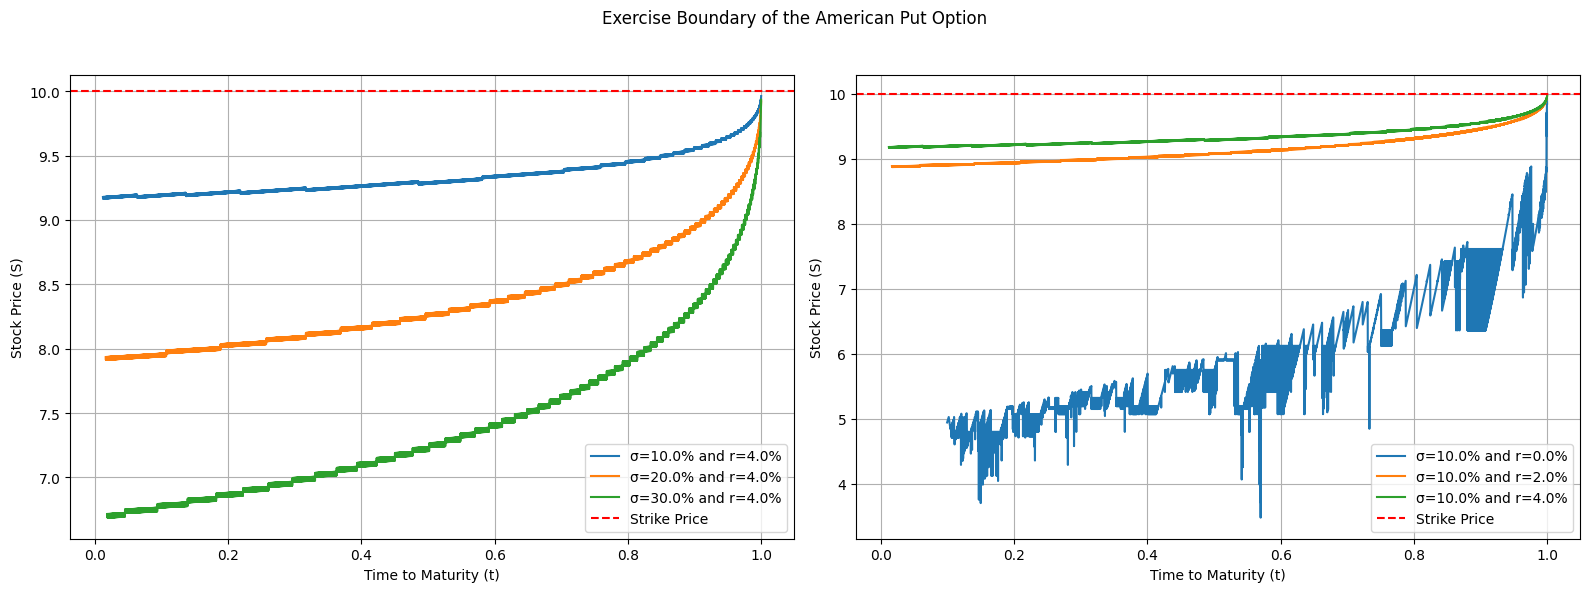

In [ ]:
np.random.seed(63)
# Input parameters
T = 1  # time to maturity
S0 = 10  # initial stock price
N = 5000  # number of time steps
K = 10  # strike price
delta_t = T / N

# Volatility and risk-free rate scenarios
volatility_scenarios = [0.10, 0.20, 0.30]
r_scenarios = [0.00, 0.02, 0.04]

# Set up subplots for visualization
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
fig.suptitle("Exercise Boundary of the American Put Option")

# Generate sample paths and exercise boundaries for each combination of volatility and risk-free rate
for idx, (volatility_set, r_set) in enumerate([([0.10, 0.20, 0.30], [0.04]), ([0.10], [0.00, 0.02, 0.04])]):
    ax = axes[idx]
    for sigma in volatility_set:
        for r in r_set:
            # Calculate up and down factors
            u = np.exp(sigma * np.sqrt(delta_t))
            d = np.exp(-sigma * np.sqrt(delta_t))
            q = 1 - (np.exp(sigma * np.sqrt(delta_t)) - 1) / (np.exp(sigma * np.sqrt(delta_t)) - np.exp(-sigma * np.sqrt(delta_t)))  # risk-neutral probability of up move

            # Step 1: Build the stock price tree
            stock_tree = build_stock_tree(S0, u, d, N)

            # Step 2: Build the option value tree for American put option
            option_tree = build_option_tree(stock_tree, K, r, q, delta_t, N)

            # Step 3: Determine the exercise boundary for the American put option
            exercise_boundary = determine_exercise_boundary(stock_tree, option_tree, K, r, q, delta_t, N)

            # Step 4: Plot the exercise boundary
            if exercise_boundary:
                times1, boundary_prices = zip(*exercise_boundary)  # Unzip times and stock prices for plotting
                ax.plot(times1, boundary_prices, label=f'σ={sigma * 100:.1f}% and r={r * 100:.1f}%')

    ax.axhline(y=K, color='red', linestyle='--', label='Strike Price')
    ax.set_xlabel("Time to Maturity (t)")
    ax.set_ylabel("Stock Price (S)")
    ax.legend()
    ax.grid(True)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


vo=0.3, r=0.0

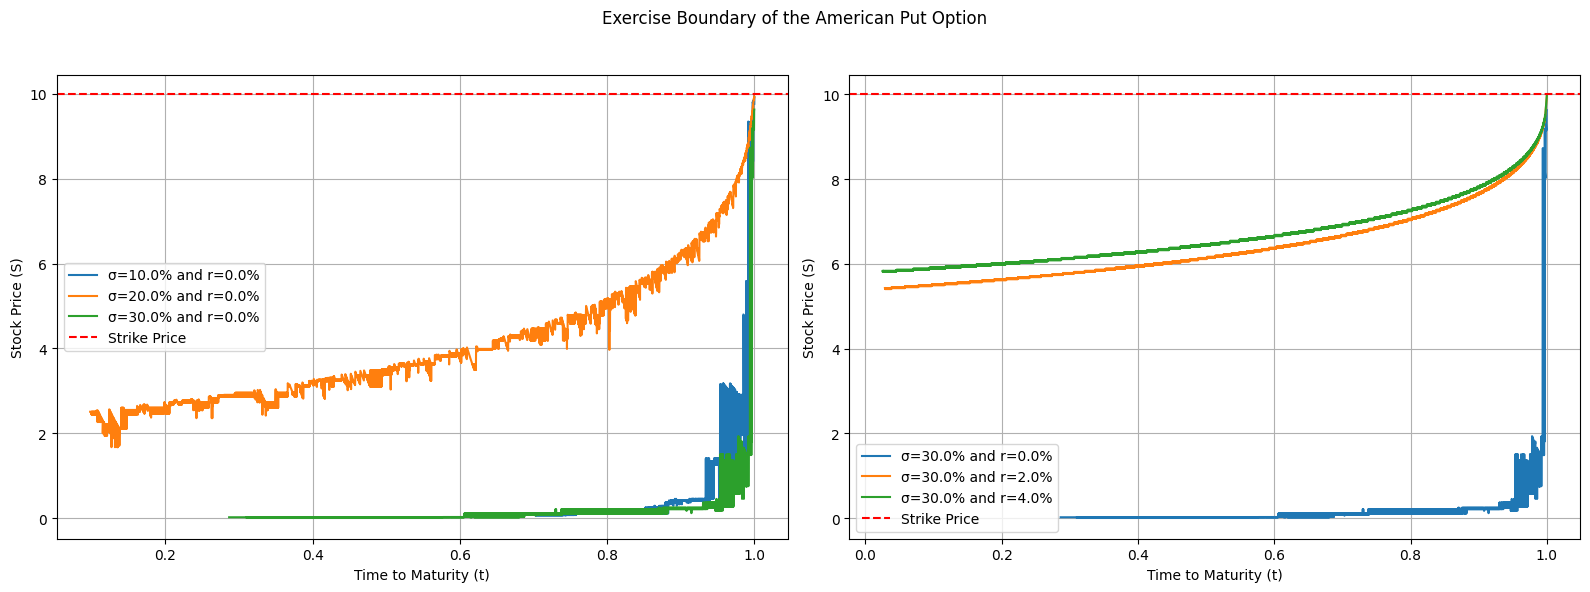

In [ ]:
np.random.seed(63)
# Set up subplots for visualization
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
fig.suptitle("Exercise Boundary of the American Put Option")
for idx, (volatility_set, r_set) in enumerate([([0.10, 0.20, 0.30], [0.00]), ([0.30], [0.00, 0.02, 0.04])]):
    ax = axes[idx]
    for sigma in volatility_set:
        for r in r_set:
            # Calculate up and down factors
            u = np.exp(sigma * np.sqrt(delta_t))
            d = np.exp(-sigma * np.sqrt(delta_t))
            q = 1 - (np.exp(sigma * np.sqrt(delta_t)) - 1) / (np.exp(sigma * np.sqrt(delta_t)) - np.exp(-sigma * np.sqrt(delta_t)))  # risk-neutral probability of up move

            # Discount factor for each step
            discount_factor = np.exp(-r * delta_t)

            # Step 1: Initialize stock prices at maturity (t = T)
            stock_prices = np.array([S0 * (u ** j) * (d ** (N - j)) for j in range(N + 1)])

            # Step 2: Calculate the option payoff at maturity
            option_values = np.maximum(K - stock_prices, 0)  # American put option payoff

            # List to store the exercise boundary at each time step
            exercise_boundary = []

            # Step 3: Perform backward induction and capture exercise boundary
            for i in range(N - 1, -1, -1):
                # Calculate stock prices at the current step
                stock_prices = stock_prices[:-1] * u  # Move one step back

                # Calculate the hold values (expected value of holding the option)
                hold_values = discount_factor * (q * option_values[1:] + (1 - q) * option_values[:-1])

                # Calculate the immediate exercise values
                exercise_values = np.maximum(K - stock_prices, 0)

                # Determine the option value as the maximum of hold and exercise values
                option_values = np.maximum(hold_values, exercise_values)

                # Identify the stock price where early exercise becomes optimal
                early_exercise_points = stock_prices[exercise_values > hold_values]
                if len(early_exercise_points) > 0:
                    # Record the maximum stock price where early exercise is optimal
                    exercise_boundary.append((i * delta_t, early_exercise_points.max()))

            # Reverse the list to plot from t=0 to T
            exercise_boundary = list(reversed(exercise_boundary))

            # Step 4: Plot the exercise boundary
            if exercise_boundary:
                times1, boundary_prices = zip(*exercise_boundary)  # Unzip times and stock prices for plotting
                ax.plot(times1, boundary_prices, label=f'σ={sigma * 100:.1f}% and r={r * 100:.1f}%')

    ax.axhline(y=K, color='red', linestyle='--', label='Strike Price')
    ax.set_xlabel("Time to Maturity (t)")
    ax.set_ylabel("Stock Price (S)")
    ax.legend()
    ax.grid(True)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

path editing

- sigma = 0.1, r = 0

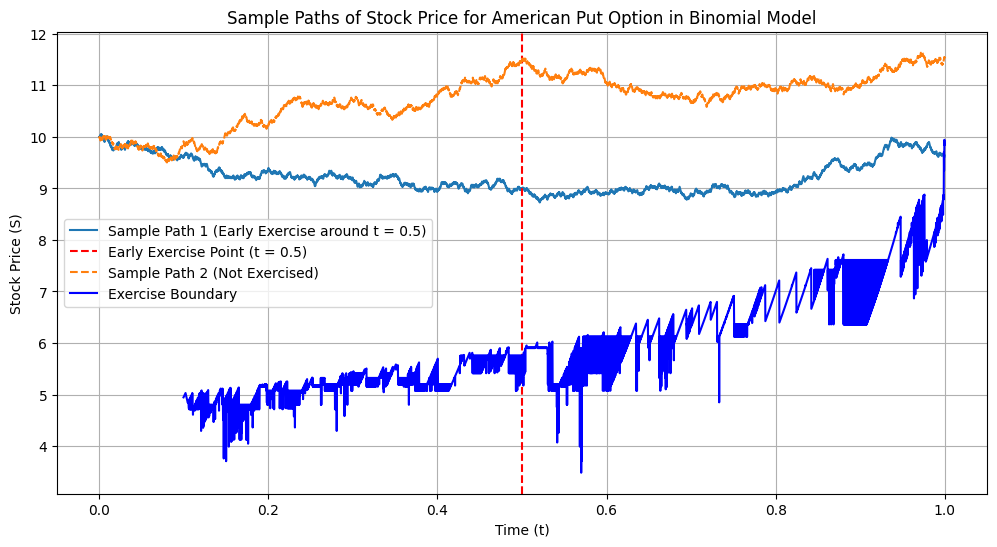

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
np.random.seed(63)
## Input parameters
T = 1  # time to maturity
S0 = 10  # initial stock price
sigma = 0.10  # volatility
r = 0.00  # risk-free rate
N = 5000  # number of time steps
K = 10  # strike price
delta_t = T / N
mu = 0.05

# Calculate up and down factors
u = np.exp(r*delta_t + sigma * np.sqrt(delta_t))
d = 1/u
p = 0.5*(1+((mu-r)-0.5*sigma**2)/sigma*np.sqrt(delta_t))

q = 1 - (np.exp(sigma * np.sqrt(delta_t)) - 1) / (np.exp(sigma * np.sqrt(delta_t)) - np.exp(-sigma * np.sqrt(delta_t)))  # risk-neutral probability of up move

            # Step 1: Build the stock price tree
stock_tree = build_stock_tree(S0, u, d, N)

            # Step 2: Build the option value tree for American put option
option_tree = build_option_tree(stock_tree, K, r, q, delta_t, N)

            # Step 3: Determine the exercise boundary for the American put option
exercise_boundary = determine_exercise_boundary(stock_tree, option_tree, K, r, q, delta_t, N)

if exercise_boundary:
  times1, boundary_prices = zip(*exercise_boundary)  # Unzip times and stock prices for plotting
# Path 1: Exercise at t = 0.5
path1 = [S0]
for i in range(N):
        path1.append(path1[-1] * (u if np.random.rand() < p else d))

# Path 2: No early exercise
path2 = [S0]
for i in range(N):
    path2.append(path2[-1] * (u if np.random.rand() < p else d))

# Generate times array for plotting
times = np.linspace(0, T, N + 1)

# Plot the sample paths
plt.figure(figsize=(12, 6))

# Plot path 1 (early exercise)
plt.plot(times, path1, label="Sample Path 1 (Early Exercise around t = 0.5)")
plt.axvline(x=0.5, color='red', linestyle='--', label="Early Exercise Point (t = 0.5)")

# Plot path 2 (not exercised)
plt.plot(times, path2, label="Sample Path 2 (Not Exercised)", linestyle='--')

plt.plot(times1, boundary_prices, label='Exercise Boundary', color='blue')

# Labels and title
plt.xlabel('Time (t)')
plt.ylabel('Stock Price (S)')
plt.title('Sample Paths of Stock Price for American Put Option in Binomial Model')
plt.legend()
plt.grid(True)
plt.show()

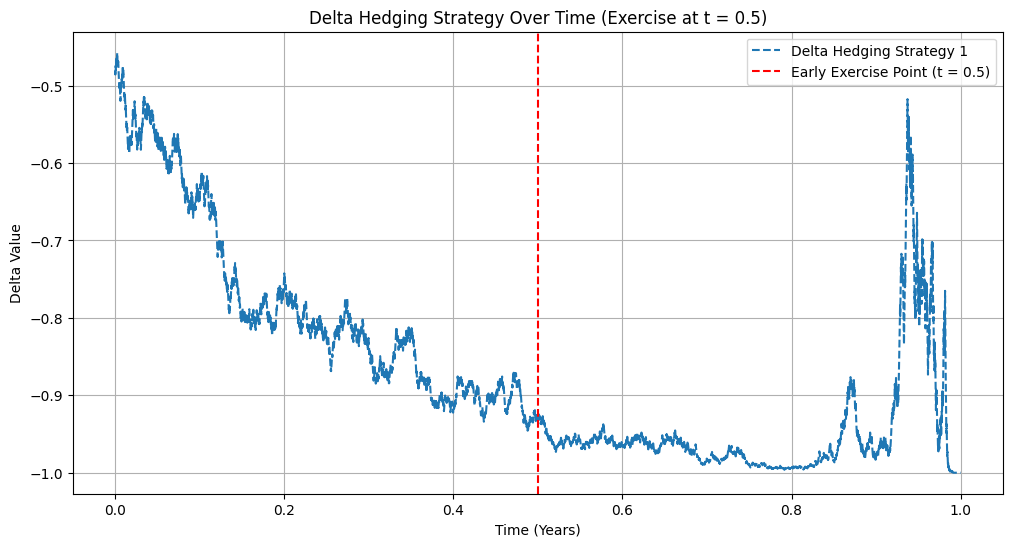

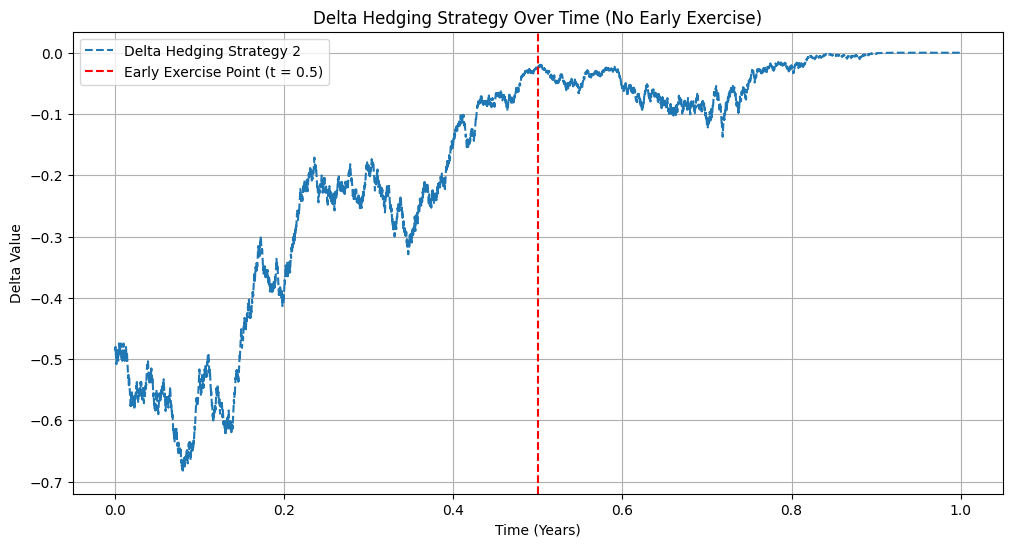

In [ ]:

np.random.seed(63)
# Generate stock price tree and option price tree
S = stock_tree
V = option_tree
N = 5000  # number of time steps
K = 10  # strike price
# Calculate delta values
delta_tree = calculate_delta(V, S, N)

# Get hedging strategies along the paths
hedging_strategy1 = get_hedging_strategy(path1, delta_tree, N)
hedging_strategy2 = get_hedging_strategy(path2, delta_tree, N)

# Plot hedging strategies
plt.figure(figsize=(12, 6))
plt.plot(np.linspace(0, T, N), hedging_strategy1, label="Delta Hedging Strategy 1", linestyle='--')
plt.axvline(x=0.5, color='red', linestyle='--', label="Early Exercise Point (t = 0.5)")
plt.xlabel('Time (Years)')
plt.ylabel('Delta Value')
plt.title('Delta Hedging Strategy Over Time (Exercise at t = 0.5)')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(np.linspace(0, T, N), hedging_strategy2, label="Delta Hedging Strategy 2", linestyle='--')
plt.axvline(x=0.5, color='red', linestyle='--', label="Early Exercise Point (t = 0.5)")
plt.xlabel('Time (Years)')
plt.ylabel('Delta Value')
plt.title('Delta Hedging Strategy Over Time (No Early Exercise)')
plt.legend()
plt.grid(True)
plt.show()


- sigma = 0.1, r = 0.02

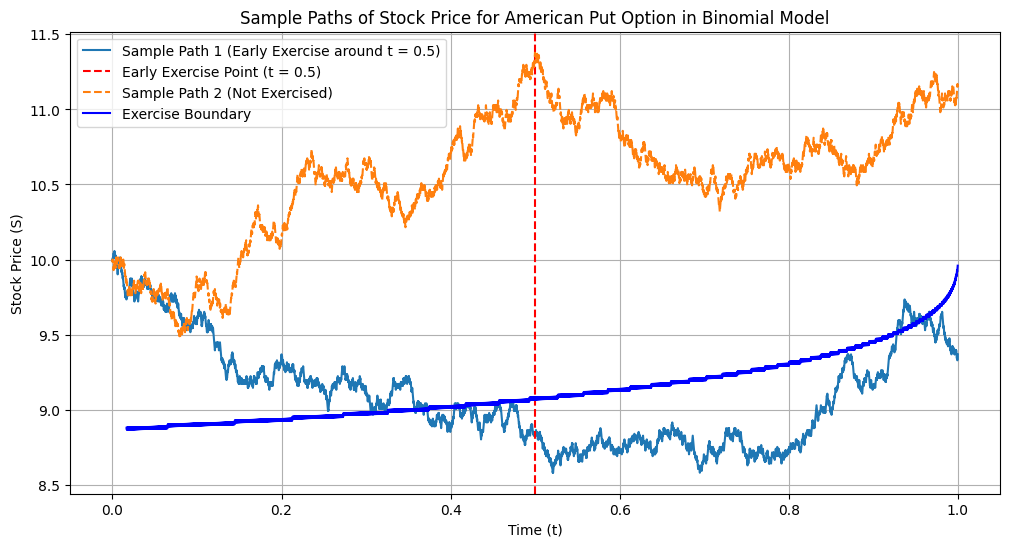

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
np.random.seed(63)
## Input parameters
T = 1  # time to maturity
S0 = 10  # initial stock price
sigma = 0.10  # volatility
r = 0.02  # risk-free rate
N = 5000  # number of time steps
K = 10  # strike price
delta_t = T / N
mu = 0.05

# Calculate up and down factors
u = np.exp(r*delta_t + sigma * np.sqrt(delta_t))
d = 1/u
p = 0.5*(1+((mu-r)-0.5*sigma**2)/sigma*np.sqrt(delta_t))

q = 1 - (np.exp(sigma * np.sqrt(delta_t)) - 1) / (np.exp(sigma * np.sqrt(delta_t)) - np.exp(-sigma * np.sqrt(delta_t)))  # risk-neutral probability of up move

            # Step 1: Build the stock price tree
stock_tree = build_stock_tree(S0, u, d, N)

            # Step 2: Build the option value tree for American put option
option_tree = build_option_tree(stock_tree, K, r, q, delta_t, N)

            # Step 3: Determine the exercise boundary for the American put option
exercise_boundary = determine_exercise_boundary(stock_tree, option_tree, K, r, q, delta_t, N)

if exercise_boundary:
  times1, boundary_prices = zip(*exercise_boundary)  # Unzip times and stock prices for plotting
# Path 1: Exercise at t = 0.5
path1 = [S0]
for i in range(N):
        path1.append(path1[-1] * (u if np.random.rand() < p else d))

# Path 2: No early exercise
path2 = [S0]
for i in range(N):
    path2.append(path2[-1] * (u if np.random.rand() < p else d))

# Generate times array for plotting
times = np.linspace(0, T, N + 1)

# Plot the sample paths
plt.figure(figsize=(12, 6))

# Plot path 1 (early exercise)
plt.plot(times, path1, label="Sample Path 1 (Early Exercise around t = 0.5)")
plt.axvline(x=0.5, color='red', linestyle='--', label="Early Exercise Point (t = 0.5)")

# Plot path 2 (not exercised)
plt.plot(times, path2, label="Sample Path 2 (Not Exercised)", linestyle='--')

plt.plot(times1, boundary_prices, label='Exercise Boundary', color='blue')

# Labels and title
plt.xlabel('Time (t)')
plt.ylabel('Stock Price (S)')
plt.title('Sample Paths of Stock Price for American Put Option in Binomial Model')
plt.legend()
plt.grid(True)
plt.show()

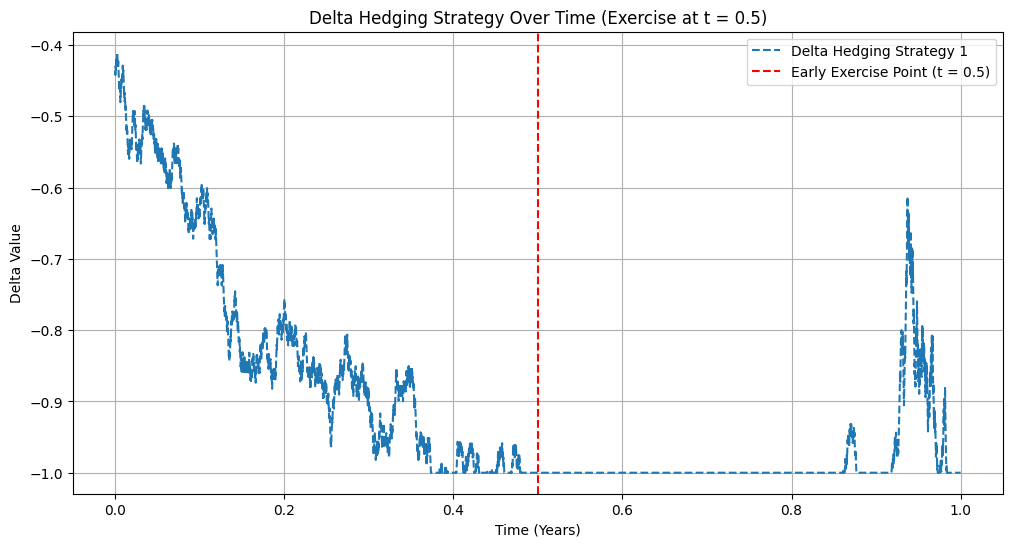

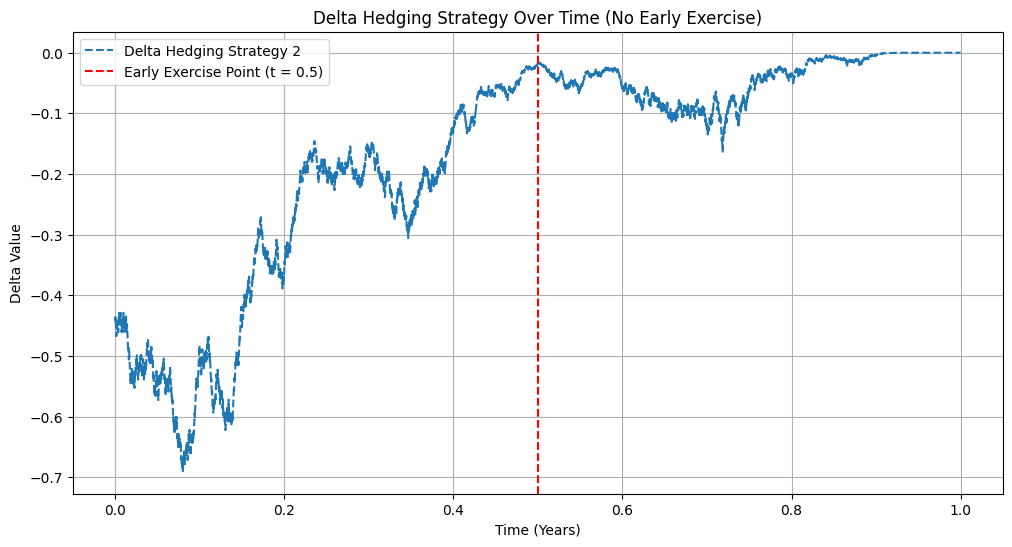

In [ ]:

np.random.seed(63)
# Generate stock price tree and option price tree
S = stock_tree
V = option_tree
N = 5000  # number of time steps
K = 10  # strike price
# Calculate delta values
delta_tree = calculate_delta(V, S, N)

# Get hedging strategies along the paths
hedging_strategy1 = get_hedging_strategy(path1, delta_tree, N)
hedging_strategy2 = get_hedging_strategy(path2, delta_tree, N)

# Plot hedging strategies
plt.figure(figsize=(12, 6))
plt.plot(np.linspace(0, T, N), hedging_strategy1, label="Delta Hedging Strategy 1", linestyle='--')
plt.axvline(x=0.5, color='red', linestyle='--', label="Early Exercise Point (t = 0.5)")
plt.xlabel('Time (Years)')
plt.ylabel('Delta Value')
plt.title('Delta Hedging Strategy Over Time (Exercise at t = 0.5)')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(np.linspace(0, T, N), hedging_strategy2, label="Delta Hedging Strategy 2", linestyle='--')
plt.axvline(x=0.5, color='red', linestyle='--', label="Early Exercise Point (t = 0.5)")
plt.xlabel('Time (Years)')
plt.ylabel('Delta Value')
plt.title('Delta Hedging Strategy Over Time (No Early Exercise)')
plt.legend()
plt.grid(True)
plt.show()


- sigma = 0.1, r = 0.04

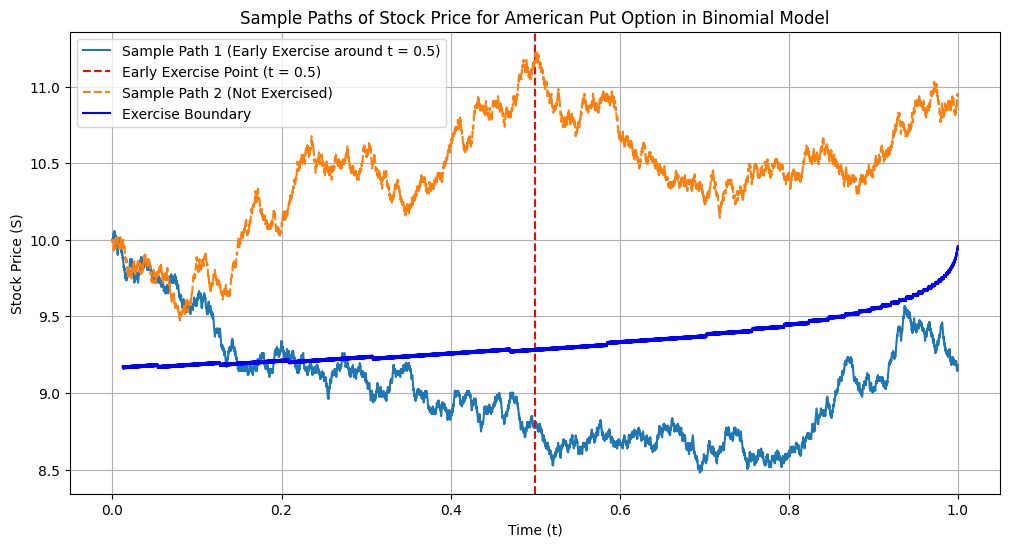

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
np.random.seed(63)
## Input parameters
T = 1  # time to maturity
S0 = 10  # initial stock price
sigma = 0.10  # volatility
r = 0.04  # risk-free rate
N = 5000  # number of time steps
K = 10  # strike price
delta_t = T / N
mu = 0.05

# Calculate up and down factors
u = np.exp(r*delta_t + sigma * np.sqrt(delta_t))
d = 1/u
p = 0.5*(1+((mu-r)-0.5*sigma**2)/sigma*np.sqrt(delta_t))

q = 1 - (np.exp(sigma * np.sqrt(delta_t)) - 1) / (np.exp(sigma * np.sqrt(delta_t)) - np.exp(-sigma * np.sqrt(delta_t)))  # risk-neutral probability of up move

            # Step 1: Build the stock price tree
stock_tree = build_stock_tree(S0, u, d, N)

            # Step 2: Build the option value tree for American put option
option_tree = build_option_tree(stock_tree, K, r, q, delta_t, N)

            # Step 3: Determine the exercise boundary for the American put option
exercise_boundary = determine_exercise_boundary(stock_tree, option_tree, K, r, q, delta_t, N)

if exercise_boundary:
  times1, boundary_prices = zip(*exercise_boundary)  # Unzip times and stock prices for plotting
# Path 1: Exercise at t = 0.5
path1 = [S0]
for i in range(N):
        path1.append(path1[-1] * (u if np.random.rand() < p else d))

# Path 2: No early exercise
path2 = [S0]
for i in range(N):
    path2.append(path2[-1] * (u if np.random.rand() < p else d))

# Generate times array for plotting
times = np.linspace(0, T, N + 1)

# Plot the sample paths
plt.figure(figsize=(12, 6))

# Plot path 1 (early exercise)
plt.plot(times, path1, label="Sample Path 1 (Early Exercise around t = 0.5)")
plt.axvline(x=0.5, color='red', linestyle='--', label="Early Exercise Point (t = 0.5)")

# Plot path 2 (not exercised)
plt.plot(times, path2, label="Sample Path 2 (Not Exercised)", linestyle='--')

plt.plot(times1, boundary_prices, label='Exercise Boundary', color='blue')

# Labels and title
plt.xlabel('Time (t)')
plt.ylabel('Stock Price (S)')
plt.title('Sample Paths of Stock Price for American Put Option in Binomial Model')
plt.legend()
plt.grid(True)
plt.show()

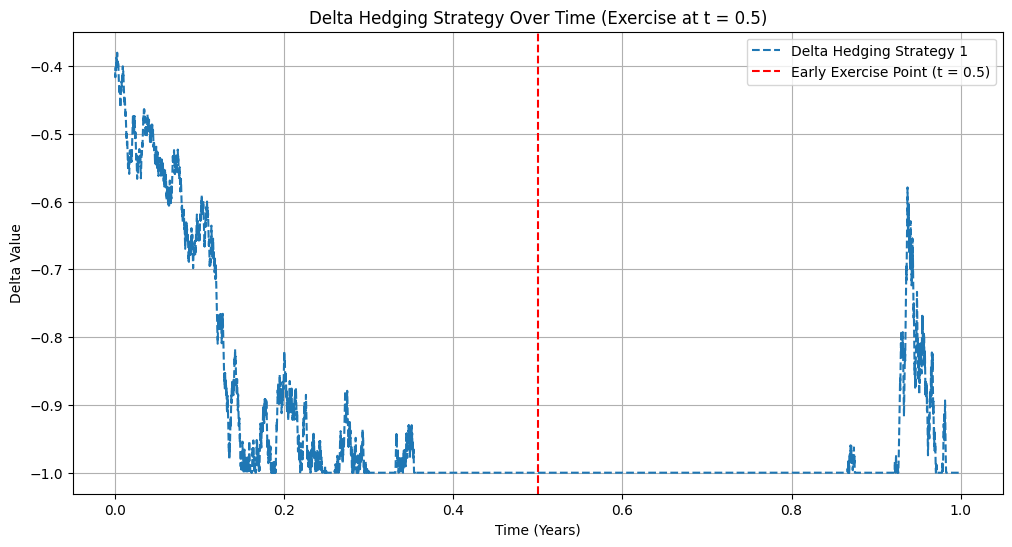

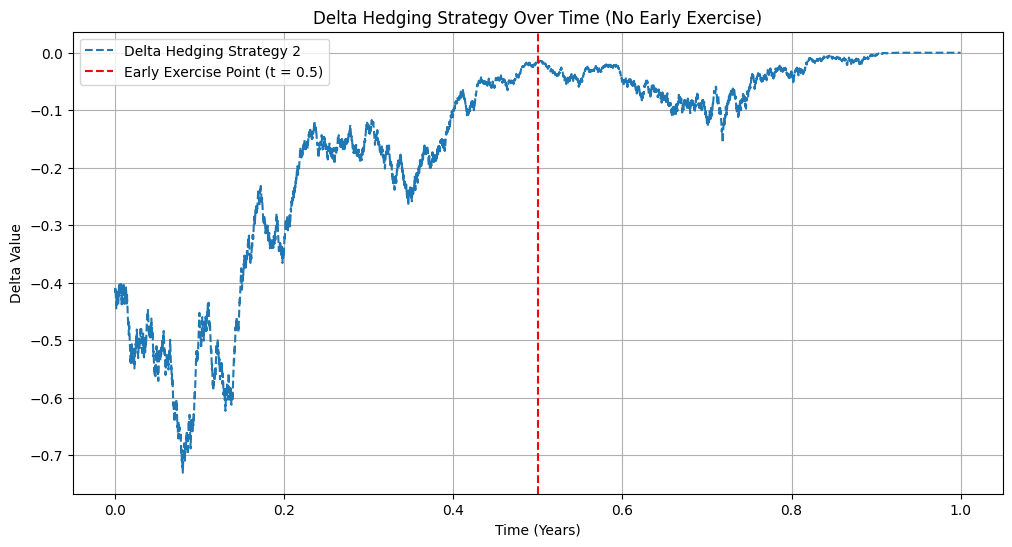

In [ ]:

np.random.seed(63)
# Generate stock price tree and option price tree
S = stock_tree
V = option_tree
N = 5000  # number of time steps
K = 10  # strike price
# Calculate delta values
delta_tree = calculate_delta(V, S, N)

# Get hedging strategies along the paths
hedging_strategy1 = get_hedging_strategy(path1, delta_tree, N)
hedging_strategy2 = get_hedging_strategy(path2, delta_tree, N)

# Plot hedging strategies
plt.figure(figsize=(12, 6))
plt.plot(np.linspace(0, T, N), hedging_strategy1, label="Delta Hedging Strategy 1", linestyle='--')
plt.axvline(x=0.5, color='red', linestyle='--', label="Early Exercise Point (t = 0.5)")
plt.xlabel('Time (Years)')
plt.ylabel('Delta Value')
plt.title('Delta Hedging Strategy Over Time (Exercise at t = 0.5)')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(np.linspace(0, T, N), hedging_strategy2, label="Delta Hedging Strategy 2", linestyle='--')
plt.axvline(x=0.5, color='red', linestyle='--', label="Early Exercise Point (t = 0.5)")
plt.xlabel('Time (Years)')
plt.ylabel('Delta Value')
plt.title('Delta Hedging Strategy Over Time (No Early Exercise)')
plt.legend()
plt.grid(True)
plt.show()


- sigma = 0.2, r = 0


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
np.random.seed(63)
## Input parameters
T = 1  # time to maturity
S0 = 10  # initial stock price
sigma = 0.20  # volatility
r = 0  # risk-free rate
N = 5000  # number of time steps
K = 10  # strike price
delta_t = T / N
mu = 0.05

# Calculate up and down factors
u = np.exp(r*delta_t + sigma * np.sqrt(delta_t))
d = 1/u
p = 0.5*(1+((mu-r)-0.5*sigma**2)/sigma*np.sqrt(delta_t))

q = 1 - (np.exp(sigma * np.sqrt(delta_t)) - 1) / (np.exp(sigma * np.sqrt(delta_t)) - np.exp(-sigma * np.sqrt(delta_t)))  # risk-neutral probability of up move

            # Step 1: Build the stock price tree
stock_tree = build_stock_tree(S0, u, d, N)

            # Step 2: Build the option value tree for American put option
option_tree = build_option_tree(stock_tree, K, r, q, delta_t, N)

            # Step 3: Determine the exercise boundary for the American put option
exercise_boundary = determine_exercise_boundary(stock_tree, option_tree, K, r, q, delta_t, N)

if exercise_boundary:
  times1, boundary_prices = zip(*exercise_boundary)  # Unzip times and stock prices for plotting
# Path 1: Exercise at t = 0.5
path1 = [S0]
for i in range(N):
        path1.append(path1[-1] * (u if np.random.rand() < p else d))

# Path 2: No early exercise
path2 = [S0]
for i in range(N):
    path2.append(path2[-1] * (u if np.random.rand() < p else d))

# Generate times array for plotting
times = np.linspace(0, T, N + 1)

# Plot the sample paths
plt.figure(figsize=(12, 6))

# Plot path 1 (early exercise)
plt.plot(times, path1, label="Sample Path 1 (Early Exercise around t = 0.5)")
plt.axvline(x=0.5, color='red', linestyle='--', label="Early Exercise Point (t = 0.5)")

# Plot path 2 (not exercised)
plt.plot(times, path2, label="Sample Path 2 (Not Exercised)", linestyle='--')

plt.plot(times1, boundary_prices, label='Exercise Boundary', color='blue')

# Labels and title
plt.xlabel('Time (t)')
plt.ylabel('Stock Price (S)')
plt.title('Sample Paths of Stock Price for American Put Option in Binomial Model')
plt.legend()
plt.grid(True)
plt.show()

KeyboardInterrupt: 

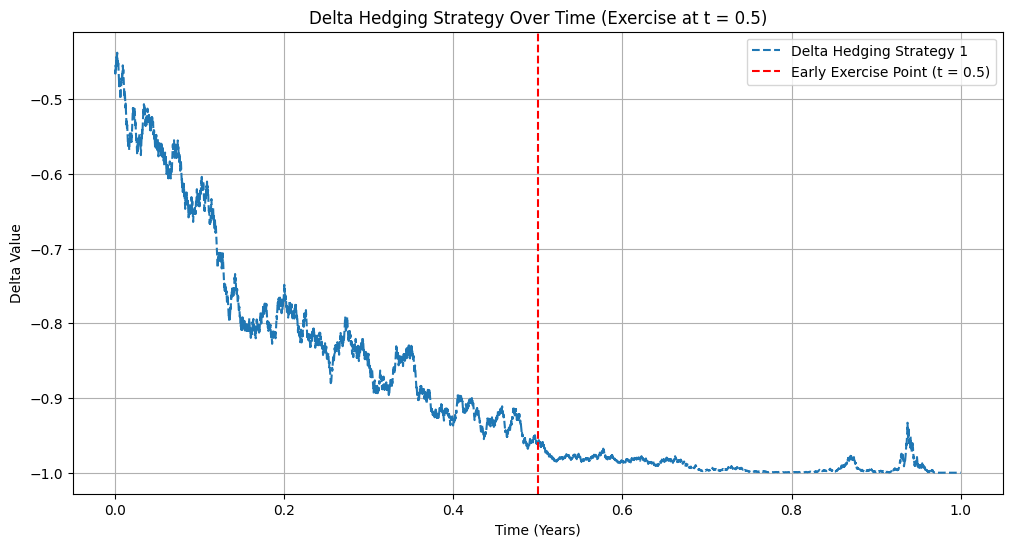

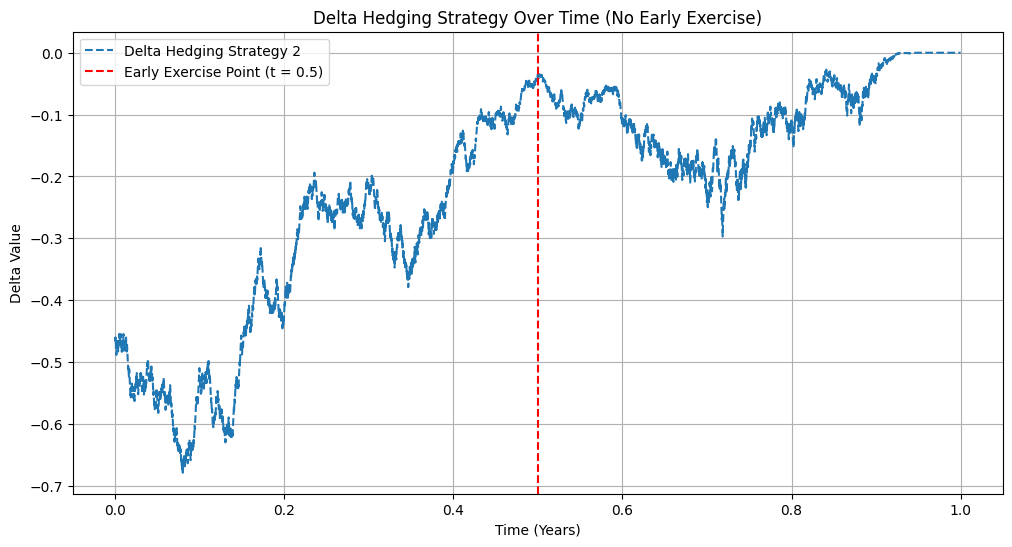

In [ ]:
# Generate stock price tree and option price tree
S = stock_tree
V = option_tree
N = 5000  # number of time steps
K = 10  # strike price
# Calculate delta values
delta_tree = calculate_delta(V, S, N)

# Get hedging strategies along the paths
hedging_strategy1 = get_hedging_strategy(path1, delta_tree, N)
hedging_strategy2 = get_hedging_strategy(path2, delta_tree, N)

# Plot hedging strategies
plt.figure(figsize=(12, 6))
plt.plot(np.linspace(0, T, N), hedging_strategy1, label="Delta Hedging Strategy 1", linestyle='--')
plt.axvline(x=0.5, color='red', linestyle='--', label="Early Exercise Point (t = 0.5)")
plt.xlabel('Time (Years)')
plt.ylabel('Delta Value')
plt.title('Delta Hedging Strategy Over Time (Exercise at t = 0.5)')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(np.linspace(0, T, N), hedging_strategy2, label="Delta Hedging Strategy 2", linestyle='--')
plt.axvline(x=0.5, color='red', linestyle='--', label="Early Exercise Point (t = 0.5)")
plt.xlabel('Time (Years)')
plt.ylabel('Delta Value')
plt.title('Delta Hedging Strategy Over Time (No Early Exercise)')
plt.legend()
plt.grid(True)
plt.show()


- sigma = 0.2, r = 0.02

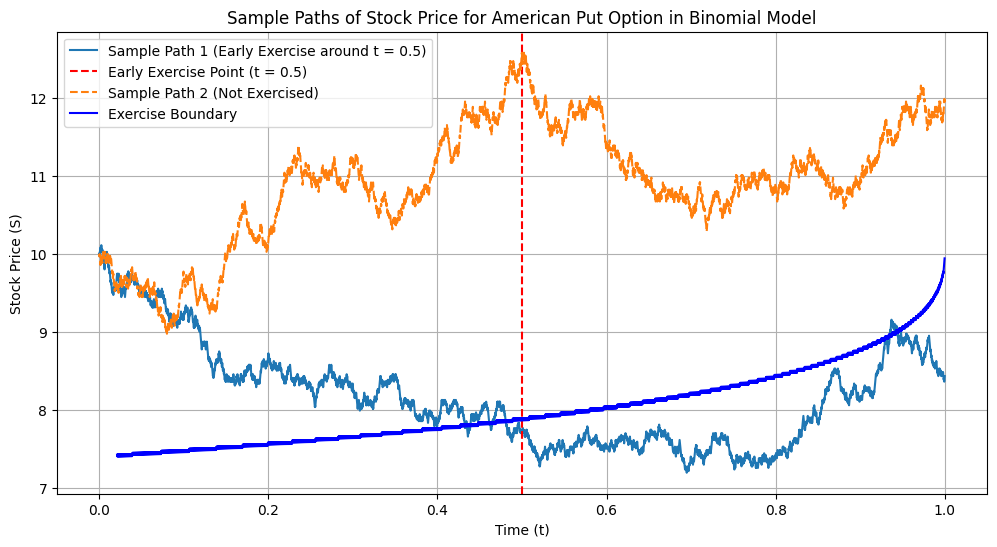

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
np.random.seed(63)
## Input parameters
T = 1  # time to maturity
S0 = 10  # initial stock price
sigma = 0.20  # volatility
r = 0.02  # risk-free rate
N = 5000  # number of time steps
K = 10  # strike price
delta_t = T / N
mu = 0.05

# Calculate up and down factors
u = np.exp(r*delta_t + sigma * np.sqrt(delta_t))
d = 1/u
p = 0.5*(1+((mu-r)-0.5*sigma**2)/sigma*np.sqrt(delta_t))

q = 1 - (np.exp(sigma * np.sqrt(delta_t)) - 1) / (np.exp(sigma * np.sqrt(delta_t)) - np.exp(-sigma * np.sqrt(delta_t)))  # risk-neutral probability of up move

            # Step 1: Build the stock price tree
stock_tree = build_stock_tree(S0, u, d, N)

            # Step 2: Build the option value tree for American put option
option_tree = build_option_tree(stock_tree, K, r, q, delta_t, N)

            # Step 3: Determine the exercise boundary for the American put option
exercise_boundary = determine_exercise_boundary(stock_tree, option_tree, K, r, q, delta_t, N)

if exercise_boundary:
  times1, boundary_prices = zip(*exercise_boundary)  # Unzip times and stock prices for plotting
# Path 1: Exercise at t = 0.5
path1 = [S0]
for i in range(N):
        path1.append(path1[-1] * (u if np.random.rand() < p else d))

# Path 2: No early exercise
path2 = [S0]
for i in range(N):
    path2.append(path2[-1] * (u if np.random.rand() < p else d))

# Generate times array for plotting
times = np.linspace(0, T, N + 1)

# Plot the sample paths
plt.figure(figsize=(12, 6))

# Plot path 1 (early exercise)
plt.plot(times, path1, label="Sample Path 1 (Early Exercise around t = 0.5)")
plt.axvline(x=0.5, color='red', linestyle='--', label="Early Exercise Point (t = 0.5)")

# Plot path 2 (not exercised)
plt.plot(times, path2, label="Sample Path 2 (Not Exercised)", linestyle='--')

plt.plot(times1, boundary_prices, label='Exercise Boundary', color='blue')

# Labels and title
plt.xlabel('Time (t)')
plt.ylabel('Stock Price (S)')
plt.title('Sample Paths of Stock Price for American Put Option in Binomial Model')
plt.legend()
plt.grid(True)
plt.show()

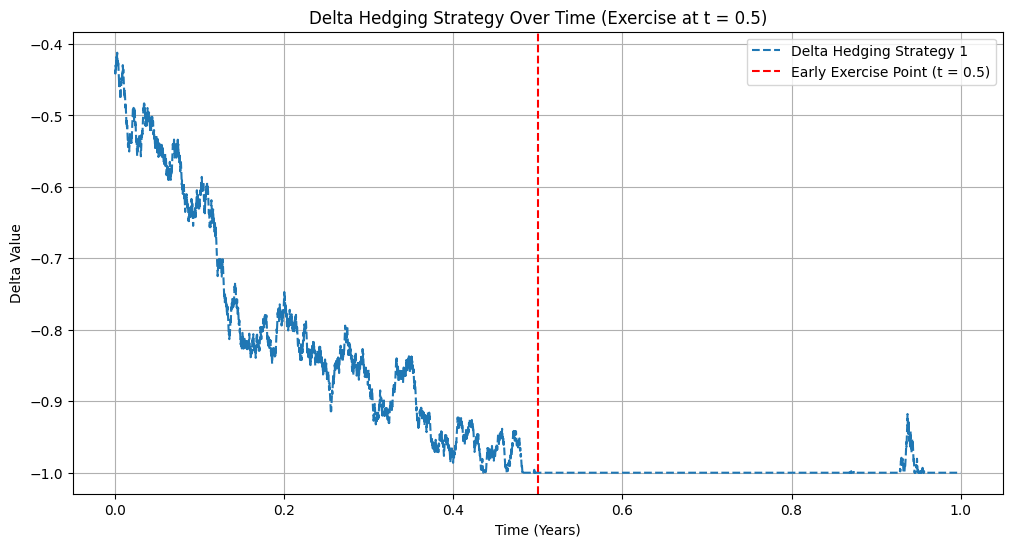

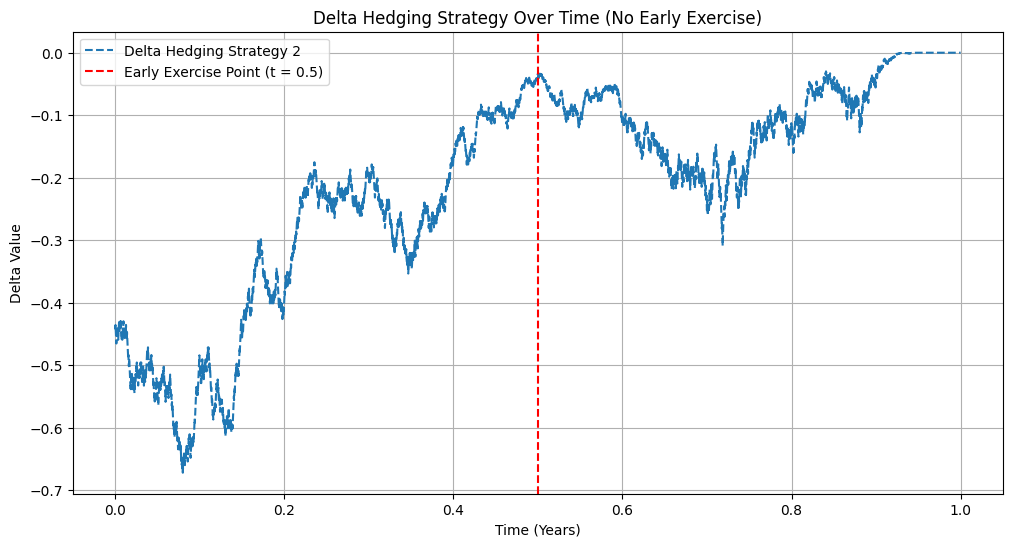

In [ ]:

np.random.seed(63)
# Generate stock price tree and option price tree
S = stock_tree
V = option_tree
N = 5000  # number of time steps
K = 10  # strike price
# Calculate delta values
delta_tree = calculate_delta(V, S, N)

# Get hedging strategies along the paths
hedging_strategy1 = get_hedging_strategy(path1, delta_tree, N)
hedging_strategy2 = get_hedging_strategy(path2, delta_tree, N)

# Plot hedging strategies
plt.figure(figsize=(12, 6))
plt.plot(np.linspace(0, T, N), hedging_strategy1, label="Delta Hedging Strategy 1", linestyle='--')
plt.axvline(x=0.5, color='red', linestyle='--', label="Early Exercise Point (t = 0.5)")
plt.xlabel('Time (Years)')
plt.ylabel('Delta Value')
plt.title('Delta Hedging Strategy Over Time (Exercise at t = 0.5)')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(np.linspace(0, T, N), hedging_strategy2, label="Delta Hedging Strategy 2", linestyle='--')
plt.axvline(x=0.5, color='red', linestyle='--', label="Early Exercise Point (t = 0.5)")
plt.xlabel('Time (Years)')
plt.ylabel('Delta Value')
plt.title('Delta Hedging Strategy Over Time (No Early Exercise)')
plt.legend()
plt.grid(True)
plt.show()


- sigma = 0.2, r = 0.04

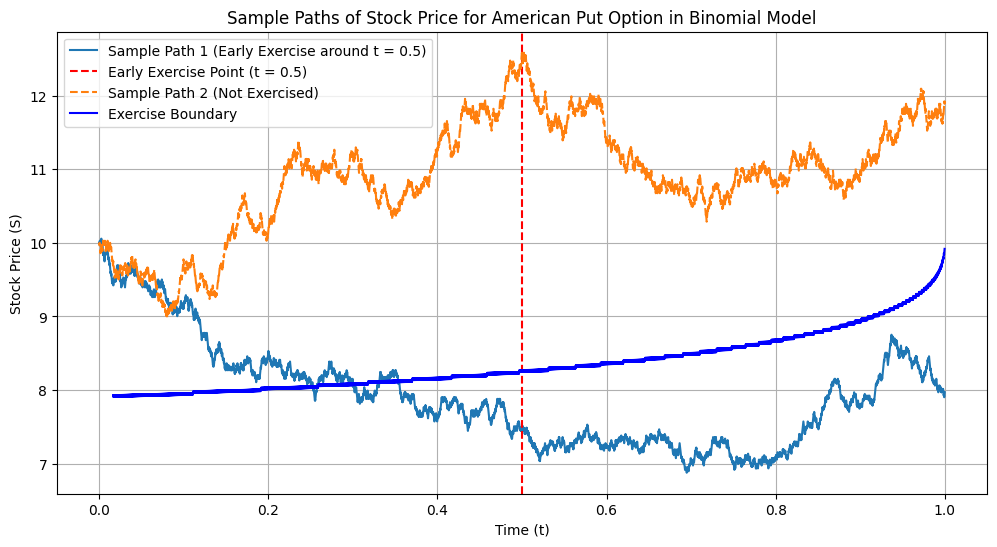

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
np.random.seed(63)
## Input parameters
T = 1  # time to maturity
S0 = 10  # initial stock price
sigma = 0.20  # volatility
r = 0.04  # risk-free rate
N = 5000  # number of time steps
K = 10  # strike price
delta_t = T / N
mu = 0.05

# Calculate up and down factors
u = np.exp(r*delta_t + sigma * np.sqrt(delta_t))
d = 1/u
p = 0.5*(1+((mu-r)-0.5*sigma**2)/sigma*np.sqrt(delta_t))

q = 1 - (np.exp(sigma * np.sqrt(delta_t)) - 1) / (np.exp(sigma * np.sqrt(delta_t)) - np.exp(-sigma * np.sqrt(delta_t)))  # risk-neutral probability of up move

            # Step 1: Build the stock price tree
stock_tree = build_stock_tree(S0, u, d, N)

            # Step 2: Build the option value tree for American put option
option_tree = build_option_tree(stock_tree, K, r, q, delta_t, N)

            # Step 3: Determine the exercise boundary for the American put option
exercise_boundary = determine_exercise_boundary(stock_tree, option_tree, K, r, q, delta_t, N)

if exercise_boundary:
  times1, boundary_prices = zip(*exercise_boundary)  # Unzip times and stock prices for plotting
# Path 1: Exercise at t = 0.5
path1 = [S0]
for i in range(N):
        path1.append(path1[-1] * (u if np.random.rand() < p else d))

# Path 2: No early exercise
path2 = [S0]
for i in range(N):
    path2.append(path2[-1] * (u if np.random.rand() < p else d))

# Generate times array for plotting
times = np.linspace(0, T, N + 1)

# Plot the sample paths
plt.figure(figsize=(12, 6))

# Plot path 1 (early exercise)
plt.plot(times, path1, label="Sample Path 1 (Early Exercise around t = 0.5)")
plt.axvline(x=0.5, color='red', linestyle='--', label="Early Exercise Point (t = 0.5)")

# Plot path 2 (not exercised)
plt.plot(times, path2, label="Sample Path 2 (Not Exercised)", linestyle='--')

plt.plot(times1, boundary_prices, label='Exercise Boundary', color='blue')

# Labels and title
plt.xlabel('Time (t)')
plt.ylabel('Stock Price (S)')
plt.title('Sample Paths of Stock Price for American Put Option in Binomial Model')
plt.legend()
plt.grid(True)
plt.show()

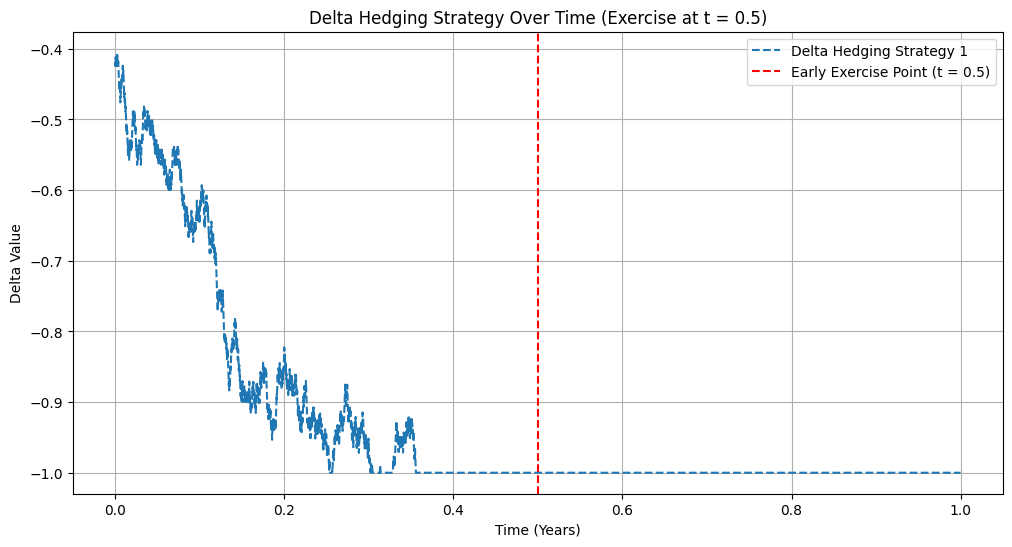

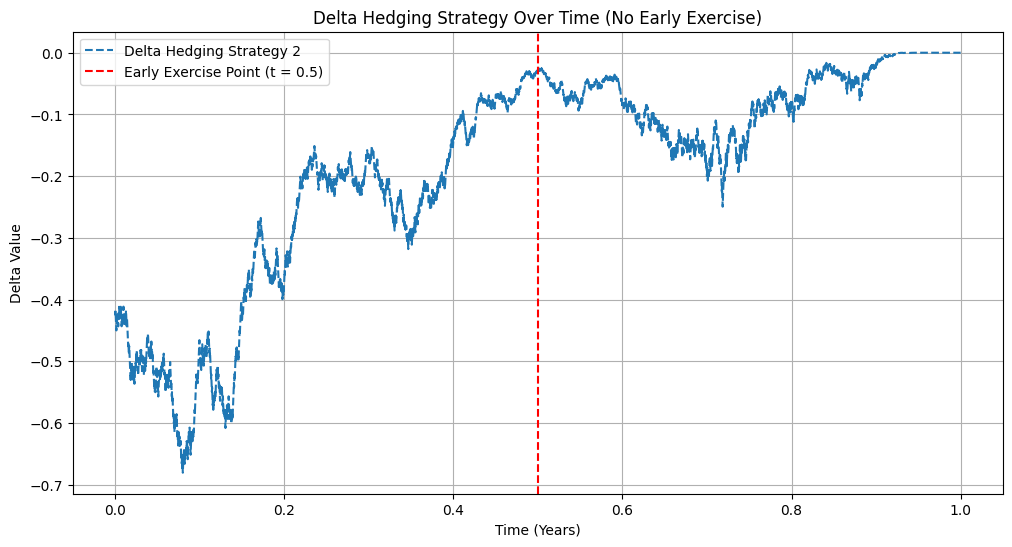

In [ ]:

np.random.seed(63)
# Generate stock price tree and option price tree
S = stock_tree
V = option_tree
N = 5000  # number of time steps
K = 10  # strike price
# Calculate delta values
delta_tree = calculate_delta(V, S, N)

# Get hedging strategies along the paths
hedging_strategy1 = get_hedging_strategy(path1, delta_tree, N)
hedging_strategy2 = get_hedging_strategy(path2, delta_tree, N)

# Plot hedging strategies
plt.figure(figsize=(12, 6))
plt.plot(np.linspace(0, T, N), hedging_strategy1, label="Delta Hedging Strategy 1", linestyle='--')
plt.axvline(x=0.5, color='red', linestyle='--', label="Early Exercise Point (t = 0.5)")
plt.xlabel('Time (Years)')
plt.ylabel('Delta Value')
plt.title('Delta Hedging Strategy Over Time (Exercise at t = 0.5)')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(np.linspace(0, T, N), hedging_strategy2, label="Delta Hedging Strategy 2", linestyle='--')
plt.axvline(x=0.5, color='red', linestyle='--', label="Early Exercise Point (t = 0.5)")
plt.xlabel('Time (Years)')
plt.ylabel('Delta Value')
plt.title('Delta Hedging Strategy Over Time (No Early Exercise)')
plt.legend()
plt.grid(True)
plt.show()


- sigma = 0.3, r = 0

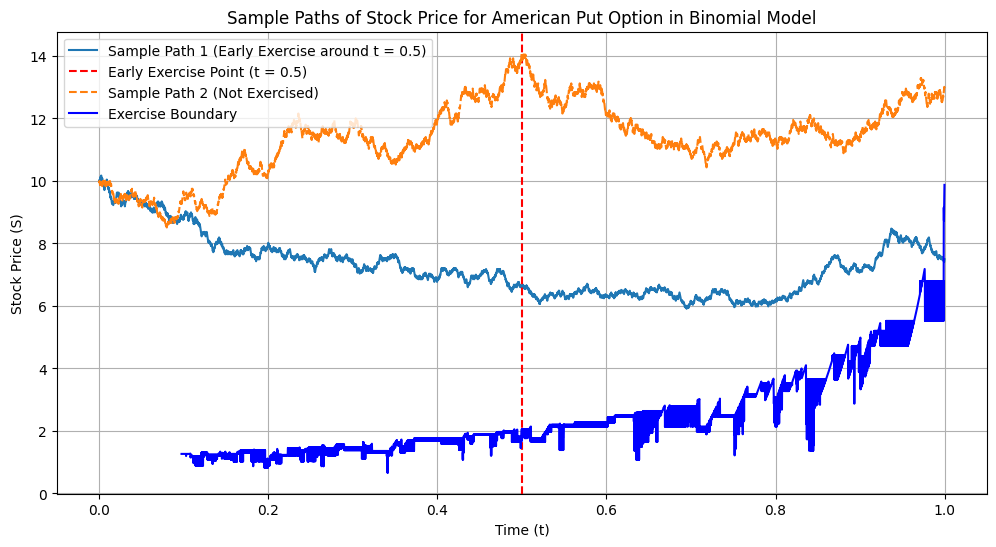

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
np.random.seed(63)
## Input parameters
T = 1  # time to maturity
S0 = 10  # initial stock price
sigma = 0.3  # volatility
r = 0  # risk-free rate
N = 5000  # number of time steps
K = 10  # strike price
delta_t = T / N
mu = 0.05

# Calculate up and down factors
u = np.exp(r*delta_t + sigma * np.sqrt(delta_t))
d = 1/u
p = 0.5*(1+((mu-r)-0.5*sigma**2)/sigma*np.sqrt(delta_t))

q = 1 - (np.exp(sigma * np.sqrt(delta_t)) - 1) / (np.exp(sigma * np.sqrt(delta_t)) - np.exp(-sigma * np.sqrt(delta_t)))  # risk-neutral probability of up move

            # Step 1: Build the stock price tree
stock_tree = build_stock_tree(S0, u, d, N)

            # Step 2: Build the option value tree for American put option
option_tree = build_option_tree(stock_tree, K, r, q, delta_t, N)

            # Step 3: Determine the exercise boundary for the American put option
exercise_boundary = determine_exercise_boundary(stock_tree, option_tree, K, r, q, delta_t, N)

if exercise_boundary:
  times1, boundary_prices = zip(*exercise_boundary)  # Unzip times and stock prices for plotting
# Path 1: Exercise at t = 0.5
path1 = [S0]
for i in range(N):
        path1.append(path1[-1] * (u if np.random.rand() < p else d))

# Path 2: No early exercise
path2 = [S0]
for i in range(N):
    path2.append(path2[-1] * (u if np.random.rand() < p else d))

# Generate times array for plotting
times = np.linspace(0, T, N + 1)

# Plot the sample paths
plt.figure(figsize=(12, 6))

# Plot path 1 (early exercise)
plt.plot(times, path1, label="Sample Path 1 (Early Exercise around t = 0.5)")
plt.axvline(x=0.5, color='red', linestyle='--', label="Early Exercise Point (t = 0.5)")

# Plot path 2 (not exercised)
plt.plot(times, path2, label="Sample Path 2 (Not Exercised)", linestyle='--')

plt.plot(times1, boundary_prices, label='Exercise Boundary', color='blue')

# Labels and title
plt.xlabel('Time (t)')
plt.ylabel('Stock Price (S)')
plt.title('Sample Paths of Stock Price for American Put Option in Binomial Model')
plt.legend()
plt.grid(True)
plt.show()

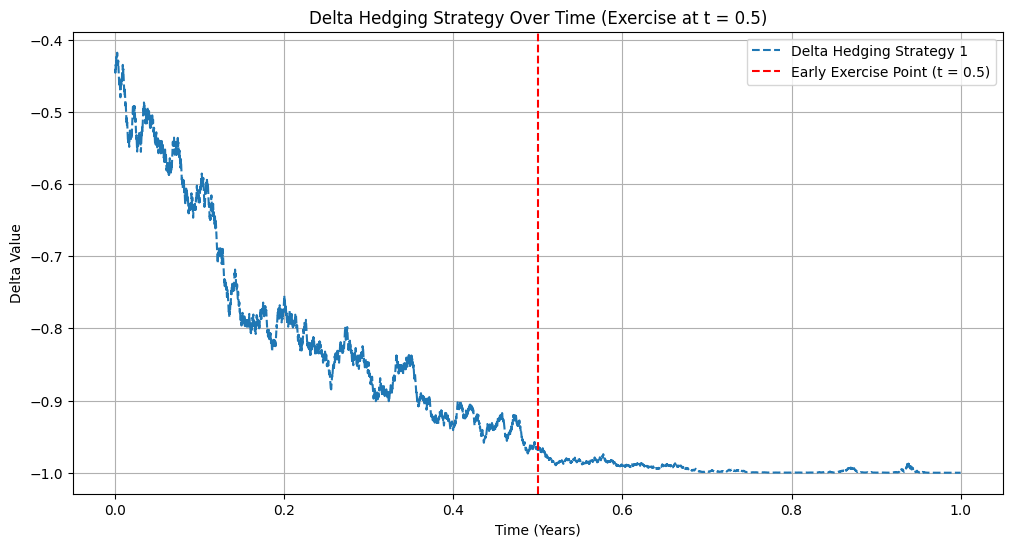

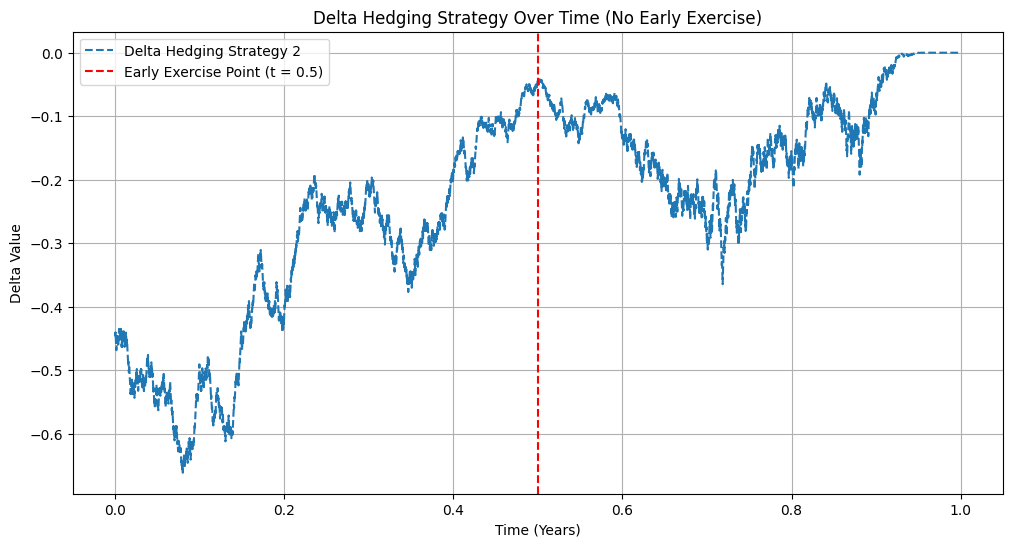

In [ ]:

np.random.seed(63)
# Generate stock price tree and option price tree
S = stock_tree
V = option_tree
N = 5000  # number of time steps
K = 10  # strike price
# Calculate delta values
delta_tree = calculate_delta(V, S, N)

# Get hedging strategies along the paths
hedging_strategy1 = get_hedging_strategy(path1, delta_tree, N)
hedging_strategy2 = get_hedging_strategy(path2, delta_tree, N)

# Plot hedging strategies
plt.figure(figsize=(12, 6))
plt.plot(np.linspace(0, T, N), hedging_strategy1, label="Delta Hedging Strategy 1", linestyle='--')
plt.axvline(x=0.5, color='red', linestyle='--', label="Early Exercise Point (t = 0.5)")
plt.xlabel('Time (Years)')
plt.ylabel('Delta Value')
plt.title('Delta Hedging Strategy Over Time (Exercise at t = 0.5)')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(np.linspace(0, T, N), hedging_strategy2, label="Delta Hedging Strategy 2", linestyle='--')
plt.axvline(x=0.5, color='red', linestyle='--', label="Early Exercise Point (t = 0.5)")
plt.xlabel('Time (Years)')
plt.ylabel('Delta Value')
plt.title('Delta Hedging Strategy Over Time (No Early Exercise)')
plt.legend()
plt.grid(True)
plt.show()


- sigma = 0.3, r = 0.02

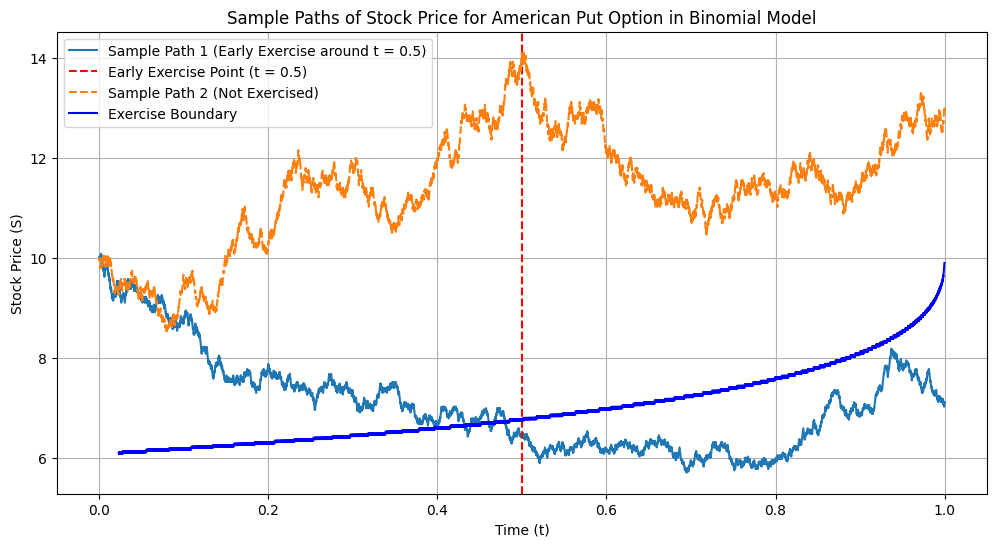

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
np.random.seed(63)
## Input parameters
T = 1  # time to maturity
S0 = 10  # initial stock price
sigma = 0.30  # volatility
r = 0.02  # risk-free rate
N = 5000  # number of time steps
K = 10  # strike price
delta_t = T / N
mu = 0.05

# Calculate up and down factors
u = np.exp(r*delta_t + sigma * np.sqrt(delta_t))
d = 1/u
p = 0.5*(1+((mu-r)-0.5*sigma**2)/sigma*np.sqrt(delta_t))

q = 1 - (np.exp(sigma * np.sqrt(delta_t)) - 1) / (np.exp(sigma * np.sqrt(delta_t)) - np.exp(-sigma * np.sqrt(delta_t)))  # risk-neutral probability of up move

            # Step 1: Build the stock price tree
stock_tree = build_stock_tree(S0, u, d, N)

            # Step 2: Build the option value tree for American put option
option_tree = build_option_tree(stock_tree, K, r, q, delta_t, N)

            # Step 3: Determine the exercise boundary for the American put option
exercise_boundary = determine_exercise_boundary(stock_tree, option_tree, K, r, q, delta_t, N)

if exercise_boundary:
  times1, boundary_prices = zip(*exercise_boundary)  # Unzip times and stock prices for plotting
# Path 1: Exercise at t = 0.5
path1 = [S0]
for i in range(N):
        path1.append(path1[-1] * (u if np.random.rand() < p else d))

# Path 2: No early exercise
path2 = [S0]
for i in range(N):
    path2.append(path2[-1] * (u if np.random.rand() < p else d))

# Generate times array for plotting
times = np.linspace(0, T, N + 1)

# Plot the sample paths
plt.figure(figsize=(12, 6))

# Plot path 1 (early exercise)
plt.plot(times, path1, label="Sample Path 1 (Early Exercise around t = 0.5)")
plt.axvline(x=0.5, color='red', linestyle='--', label="Early Exercise Point (t = 0.5)")

# Plot path 2 (not exercised)
plt.plot(times, path2, label="Sample Path 2 (Not Exercised)", linestyle='--')

plt.plot(times1, boundary_prices, label='Exercise Boundary', color='blue')

# Labels and title
plt.xlabel('Time (t)')
plt.ylabel('Stock Price (S)')
plt.title('Sample Paths of Stock Price for American Put Option in Binomial Model')
plt.legend()
plt.grid(True)
plt.show()

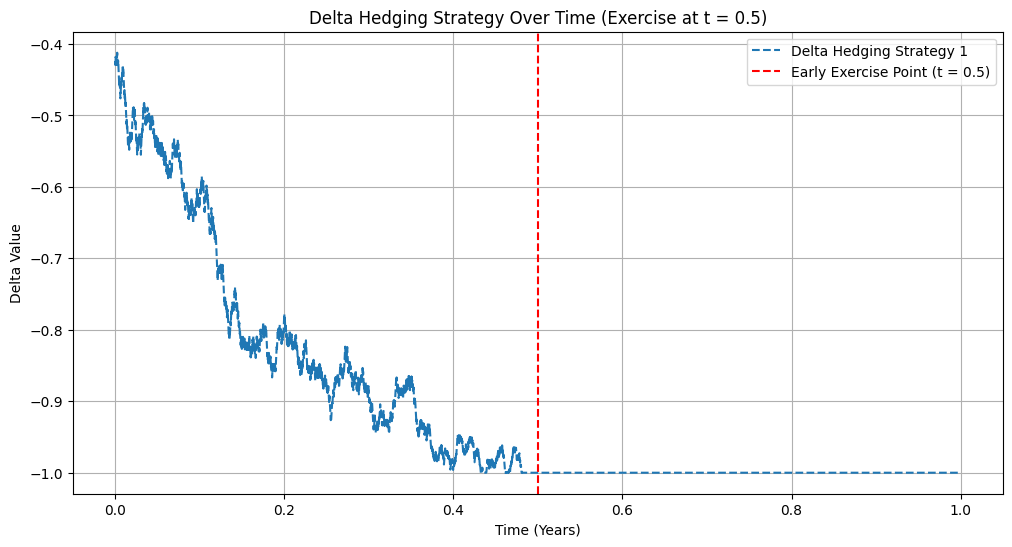

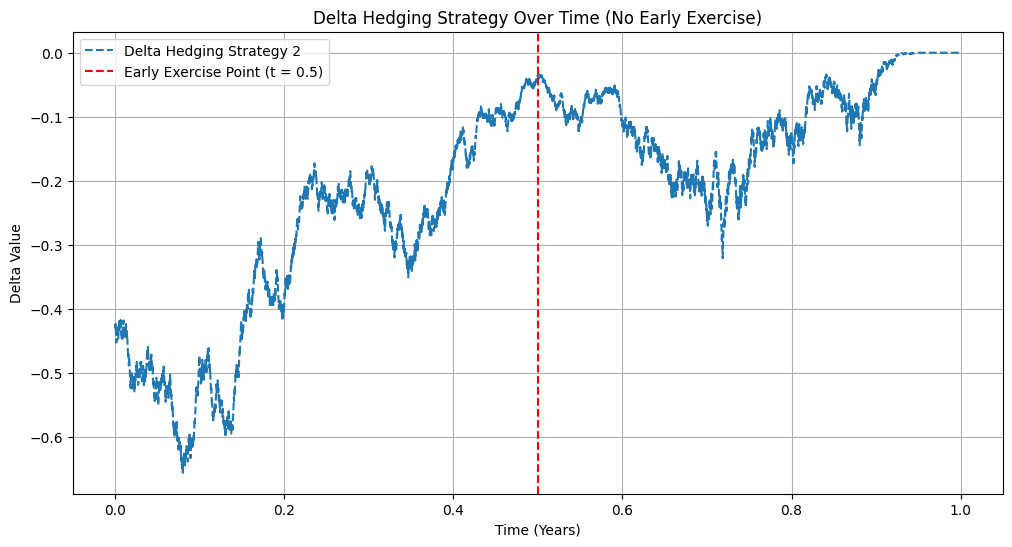

In [ ]:
# Generate stock price tree and option price tree
S = stock_tree
V = option_tree
N = 5000  # number of time steps
K = 10  # strike price
# Calculate delta values
delta_tree = calculate_delta(V, S, N)

# Get hedging strategies along the paths
hedging_strategy1 = get_hedging_strategy(path1, delta_tree, N)
hedging_strategy2 = get_hedging_strategy(path2, delta_tree, N)

# Plot hedging strategies
plt.figure(figsize=(12, 6))
plt.plot(np.linspace(0, T, N), hedging_strategy1, label="Delta Hedging Strategy 1", linestyle='--')
plt.axvline(x=0.5, color='red', linestyle='--', label="Early Exercise Point (t = 0.5)")
plt.xlabel('Time (Years)')
plt.ylabel('Delta Value')
plt.title('Delta Hedging Strategy Over Time (Exercise at t = 0.5)')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(np.linspace(0, T, N), hedging_strategy2, label="Delta Hedging Strategy 2", linestyle='--')
plt.axvline(x=0.5, color='red', linestyle='--', label="Early Exercise Point (t = 0.5)")
plt.xlabel('Time (Years)')
plt.ylabel('Delta Value')
plt.title('Delta Hedging Strategy Over Time (No Early Exercise)')
plt.legend()
plt.grid(True)
plt.show()


- sigma = 0.3, r = 0.04

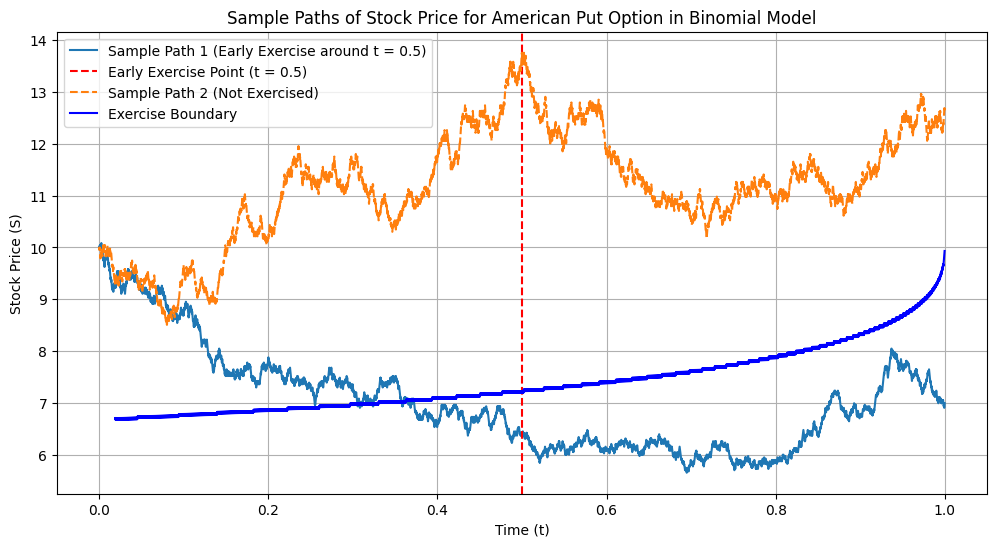

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
np.random.seed(63)
## Input parameters
T = 1  # time to maturity
S0 = 10  # initial stock price
sigma = 0.30  # volatility
r = 0.04  # risk-free rate
N = 5000  # number of time steps
K = 10  # strike price
delta_t = T / N
mu = 0.05

# Calculate up and down factors
u = np.exp(r*delta_t + sigma * np.sqrt(delta_t))
d = 1/u
p = 0.5*(1+((mu-r)-0.5*sigma**2)/sigma*np.sqrt(delta_t))

q = 1 - (np.exp(sigma * np.sqrt(delta_t)) - 1) / (np.exp(sigma * np.sqrt(delta_t)) - np.exp(-sigma * np.sqrt(delta_t)))  # risk-neutral probability of up move

            # Step 1: Build the stock price tree
stock_tree = build_stock_tree(S0, u, d, N)

            # Step 2: Build the option value tree for American put option
option_tree = build_option_tree(stock_tree, K, r, q, delta_t, N)

            # Step 3: Determine the exercise boundary for the American put option
exercise_boundary = determine_exercise_boundary(stock_tree, option_tree, K, r, q, delta_t, N)

if exercise_boundary:
  times1, boundary_prices = zip(*exercise_boundary)  # Unzip times and stock prices for plotting
# Path 1: Exercise at t = 0.5
path1 = [S0]
for i in range(N):
        path1.append(path1[-1] * (u if np.random.rand() < p else d))

# Path 2: No early exercise
path2 = [S0]
for i in range(N):
    path2.append(path2[-1] * (u if np.random.rand() < p else d))

# Generate times array for plotting
times = np.linspace(0, T, N + 1)

# Plot the sample paths
plt.figure(figsize=(12, 6))

# Plot path 1 (early exercise)
plt.plot(times, path1, label="Sample Path 1 (Early Exercise around t = 0.5)")
plt.axvline(x=0.5, color='red', linestyle='--', label="Early Exercise Point (t = 0.5)")

# Plot path 2 (not exercised)
plt.plot(times, path2, label="Sample Path 2 (Not Exercised)", linestyle='--')

plt.plot(times1, boundary_prices, label='Exercise Boundary', color='blue')

# Labels and title
plt.xlabel('Time (t)')
plt.ylabel('Stock Price (S)')
plt.title('Sample Paths of Stock Price for American Put Option in Binomial Model')
plt.legend()
plt.grid(True)
plt.show()

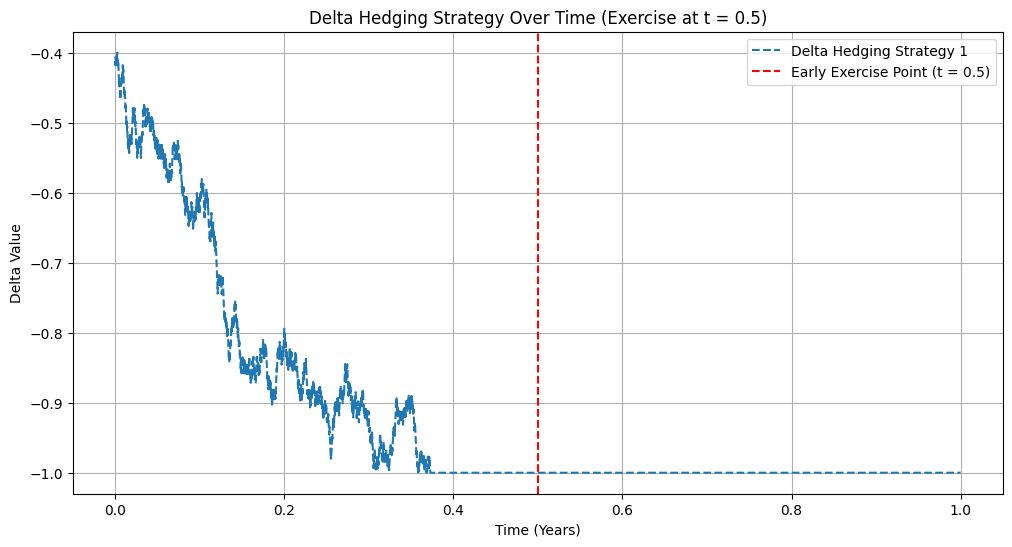

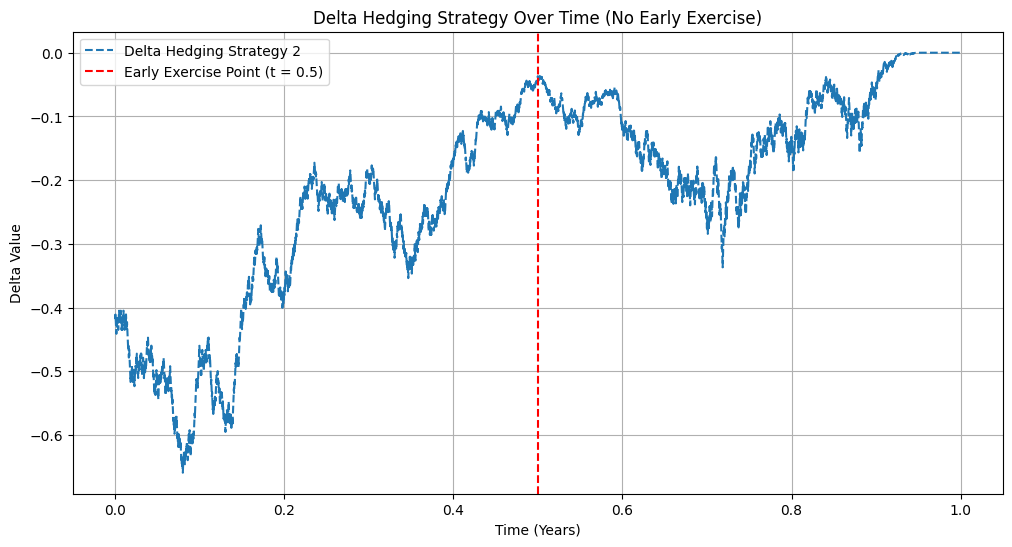

In [ ]:
# Generate stock price tree and option price tree
S = stock_tree
V = option_tree
N = 5000  # number of time steps
K = 10  # strike price
# Calculate delta values
delta_tree = calculate_delta(V, S, N)

# Get hedging strategies along the paths
hedging_strategy1 = get_hedging_strategy(path1, delta_tree, N)
hedging_strategy2 = get_hedging_strategy(path2, delta_tree, N)

# Plot hedging strategies
plt.figure(figsize=(12, 6))
plt.plot(np.linspace(0, T, N), hedging_strategy1, label="Delta Hedging Strategy 1", linestyle='--')
plt.axvline(x=0.5, color='red', linestyle='--', label="Early Exercise Point (t = 0.5)")
plt.xlabel('Time (Years)')
plt.ylabel('Delta Value')
plt.title('Delta Hedging Strategy Over Time (Exercise at t = 0.5)')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(np.linspace(0, T, N), hedging_strategy2, label="Delta Hedging Strategy 2", linestyle='--')
plt.axvline(x=0.5, color='red', linestyle='--', label="Early Exercise Point (t = 0.5)")
plt.xlabel('Time (Years)')
plt.ylabel('Delta Value')
plt.title('Delta Hedging Strategy Over Time (No Early Exercise)')
plt.legend()
plt.grid(True)
plt.show()


# 2b

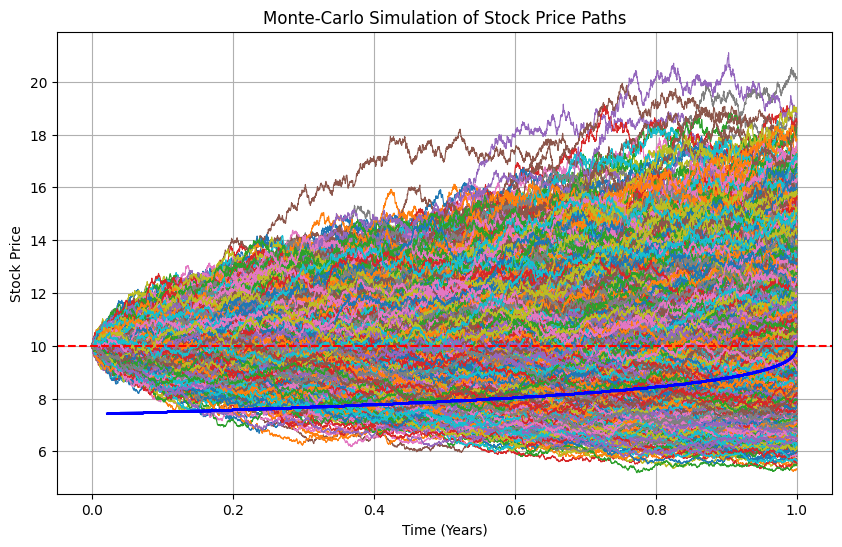

In [ ]:
# Monte-Carlo Simulation for stock paths
def monte_carlo_stock_simulation(S0, T, r, sigma, n_paths, N):
    """
    Simulate stock paths using Monte-Carlo method.

    Parameters:
    S0 : float : Initial stock price
    T : float : Time to maturity
    r : float : Risk-free interest rate
    sigma : float : Volatility of the stock
    n_paths : int : Number of simulation paths
    N : int : Number of time steps

    Returns:
    numpy.ndarray : Simulated stock paths
    """
    dt = T / N
    paths = np.zeros((n_paths, N + 1))
    paths[:, 0] = S0

    for t in range(1, N + 1):
        z = np.random.standard_normal(n_paths)
        paths[:, t] = paths[:, t - 1] * np.exp((r - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * z)

    return paths

np.random.seed(63)
n_paths = 10000
stock_paths = monte_carlo_stock_simulation(S0, T, r, sigma, n_paths, N)
# Plot a few simulated stock paths
plt.figure(figsize=(10, 6))
for i in range(N):  # Plot only 10 paths for clarity
    plt.plot(np.linspace(0, T, N + 1), stock_paths[i, :], lw=0.8)
plt.plot(times1, boundary_prices, label='Exercise Boundary', color='blue')
plt.axhline(y=K, color='red', linestyle='--', label='Strike Price')
plt.xlabel('Time (Years)')
plt.ylabel('Stock Price')
plt.title('Monte-Carlo Simulation of Stock Price Paths')
plt.grid(True)
plt.show()


In [ ]:
def exercise_boundary_with_index(stock_tree, option_tree, K, r, q, delta_t, N):
    """
    Determine the exercise boundary for an American put option.

    Parameters:
    stock_tree : numpy.ndarray : Stock price tree
    option_tree : numpy.ndarray : Option value tree
    K : float : Strike price
    r : float : Risk-free rate
    q : float : Risk-neutral probability
    delta_t : float : Time step size
    N : int : Number of time steps

    Returns:
    list : List of tuples representing the exercise boundary (time, stock price)
    """
    discount_factor = np.exp(-r * delta_t)
    exercise_boundary = []
    boundary_index = []

    for i in range(N):
        max_stock_price_for_exercise = None
        for j in range(i + 1):
            hold_value = discount_factor * (q * option_tree[i + 1, j + 1] + (1 - q) * option_tree[i + 1, j])
            exercise_value = max(K - stock_tree[i, j], 0)

            if exercise_value > hold_value:
                if max_stock_price_for_exercise is None or stock_tree[i, j] > max_stock_price_for_exercise:
                    max_stock_price_for_exercise = stock_tree[i, j]

        if max_stock_price_for_exercise is not None:
            exercise_boundary.append((i * delta_t, max_stock_price_for_exercise))
            boundary_index.append(i)

    return exercise_boundary, boundary_index

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Simulate P&L and stopping time
def simulate_PnL_stopping_time(S0, N, u, d, P, exercise_boundary, K, V, r, dt):
    n_paths = 10000
    paths = np.zeros((n_paths, N + 1))
    paths[:, 0] = S0
    for t in range(1, N + 1):
        random_numbers = np.random.rand(n_paths)
        paths[:, t] = paths[:, t - 1] * np.where(random_numbers < P, u, d)

    PL = [None] * n_paths
    stopping_times = [None] * n_paths

    for i in range(n_paths):
        for step, boundary_price in exercise_boundary:
            # Convert time to an integer index
            t = int(round(step / dt))

            if paths[i, t] <= boundary_price: # under boundary, early exercise -> stop
                PL[i] = np.exp(r * (1 - t / N)) * (K - paths[i, t]) - V[0][0]  # P&L is the intrinsic value at exercise
                stopping_times[i] = t / N  # Record stopping time
                break
        if all(paths[i, int(round(step / dt))] > boundary_price for step, boundary_price in exercise_boundary):  # no early exercise
            if max(K - paths[i, -1], 0) > 0:  # In the money at maturity
                PL[i] = max(K - paths[i, -1], 0) - V[0][0]
                stopping_times[i] = N / N
    # Remove all None values
    PL = [x for x in PL if x is not None]
    stopping_times = [x for x in stopping_times if x is not None]
    exercise_probability = len(stopping_times) / n_paths
        # Output results: P&L, stopping times, and exercise probability
    print("Average P&L:", np.mean(PL))
    print("Exercise Probability:", exercise_probability)

    # Histogram of stopping time
    plt.hist(stopping_times, bins=25, edgecolor='black')
    plt.xlabel('Stopping Time')
    plt.ylabel('Frequency')
    plt.title('Stopping Time Distribution')
    plt.grid(True)
    plt.show()

    # Histogram of P&L
    plt.hist(PL, bins=25, edgecolor='black')
    plt.xlabel('P&L')
    plt.ylabel('Frequency')
    plt.title('P&L Distribution of American Put Option')
    plt.grid(True)
    plt.show()

    # Print the number of zero-payoff in the P&L
    print("Number of zero-payoff in P&L:", PL.count(V[0][0]))

    #return PL, stopping_times


#ii)


σ = 10%, 20%, 30% and r = 0%, 2%, 4%
- sigma = 0.1, r = 0

Average P&L: 0.015174955081415815
Exercise Probability: 0.3285


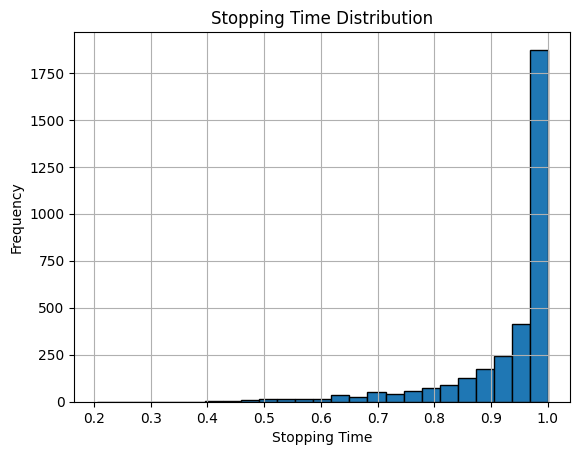

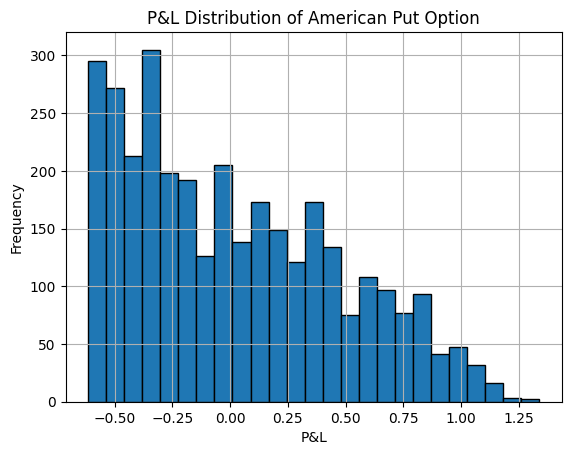

Number of zero-payoff in P&L: 0


In [ ]:
# Input parameters
T = 1  # time to maturity
S0 = 10  # initial stock price
sigma = 0.10  # volatility
r = 0.00  # risk-free rate
N = 5000  # number of time steps
K = 10  # strike price

# Calculate delta t
delta_t = T / N

# Calculate up and down factors
u = np.exp(sigma * np.sqrt(delta_t))
d = 1/u
q = (1-np.exp(-sigma * np.sqrt(delta_t)))/(np.exp(sigma * np.sqrt(delta_t))-np.exp(-1*sigma * np.sqrt(delta_t)))  # risk-neutral probability of up move
P = 0.5*(1+((mu-r)-0.5*sigma**2)/sigma*np.sqrt(delta_t))
exercise_boundary, boundary_index = exercise_boundary_with_index(stock_tree, option_tree, K, r, q, delta_t, N)
V = option_tree
S = stock_tree
simulate_PnL_stopping_time(S0, N, u, d, P, exercise_boundary, K, V, r, delta_t)

- sigma = 0.1, r = 0.02

Average P&L: 0.06048955573692768
Exercise Probability: 0.3964


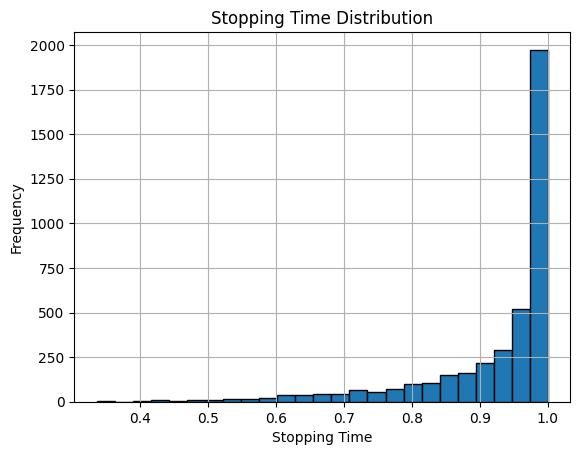

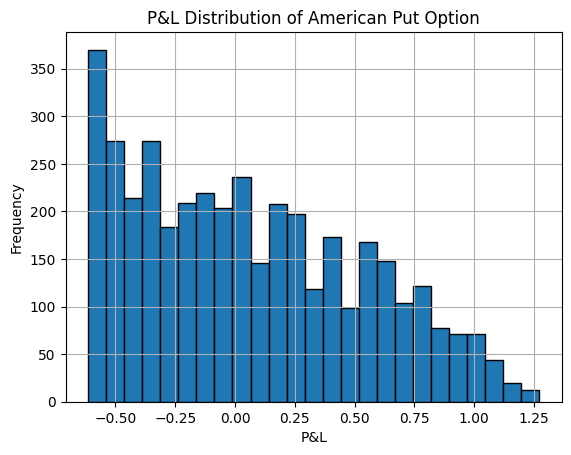

Number of zero-payoff in P&L: 0


In [ ]:
# Input parameters
T = 1  # time to maturity
S0 = 10  # initial stock price
sigma = 0.10  # volatility
r = 0.02  # risk-free rate
N = 5000  # number of time steps
K = 10  # strike price

# Calculate delta t
delta_t = T / N

# Calculate up and down factors
u = np.exp(sigma * np.sqrt(delta_t))
d = 1/u
q = (1-np.exp(-sigma * np.sqrt(delta_t)))/(np.exp(sigma * np.sqrt(delta_t))-np.exp(-1*sigma * np.sqrt(delta_t)))  # risk-neutral probability of up move
P = 0.5*(1+((mu-r)-0.5*sigma**2)/sigma*np.sqrt(delta_t))
exercise_boundary, boundary_index = exercise_boundary_with_index(stock_tree, option_tree, K, r, q, delta_t, N)
V = option_tree
S = stock_tree
simulate_PnL_stopping_time(S0, N, u, d, P, exercise_boundary, K, V, r, delta_t)

- sigma = 0.1, r = 0.04

Average P&L: 0.11804191150388758
Exercise Probability: 0.4782


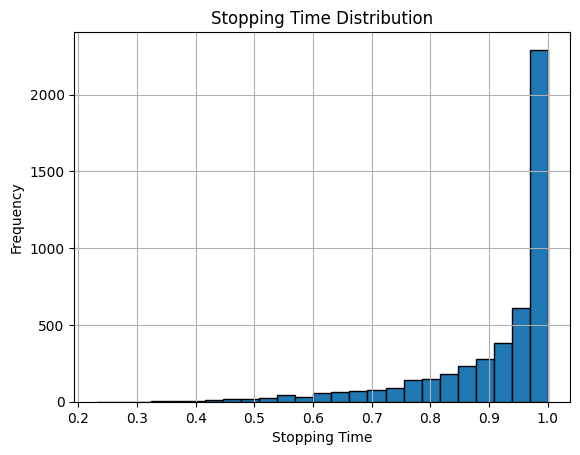

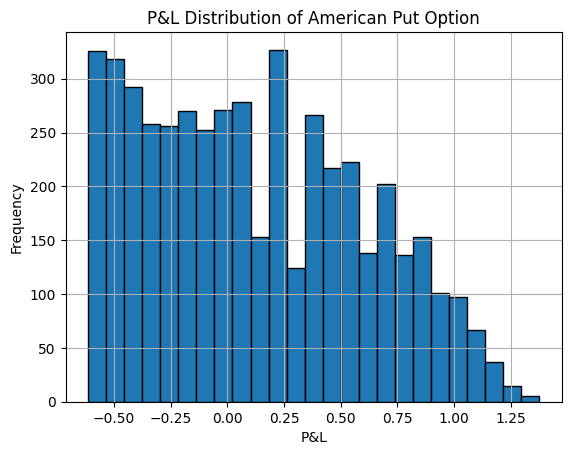

Number of zero-payoff in P&L: 0


In [ ]:
# Input parameters
T = 1  # time to maturity
S0 = 10  # initial stock price
sigma = 0.10  # volatility
r = 0.04  # risk-free rate
N = 5000  # number of time steps
K = 10  # strike price

# Calculate delta t
delta_t = T / N

# Calculate up and down factors
u = np.exp(sigma * np.sqrt(delta_t))
d = 1/u
np.random.seed(63)
q = (1-np.exp(-sigma * np.sqrt(delta_t)))/(np.exp(sigma * np.sqrt(delta_t))-np.exp(-1*sigma * np.sqrt(delta_t)))  # risk-neutral probability of up move
P = 0.5*(1+((mu-r)-0.5*sigma**2)/sigma*np.sqrt(delta_t))
exercise_boundary, boundary_index = exercise_boundary_with_index(stock_tree, option_tree, K, r, q, delta_t, N)
V = option_tree
S = stock_tree
simulate_PnL_stopping_time(S0, N, u, d, P, exercise_boundary, K, V, r, delta_t)

- sigma = 0.2, r = 0.00

Average P&L: 0.6711119165150354
Exercise Probability: 0.481


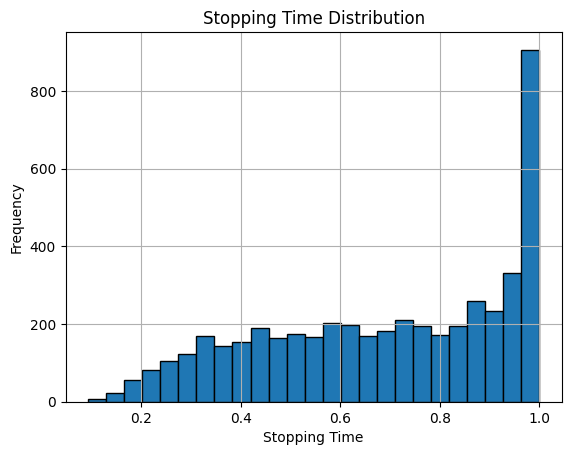

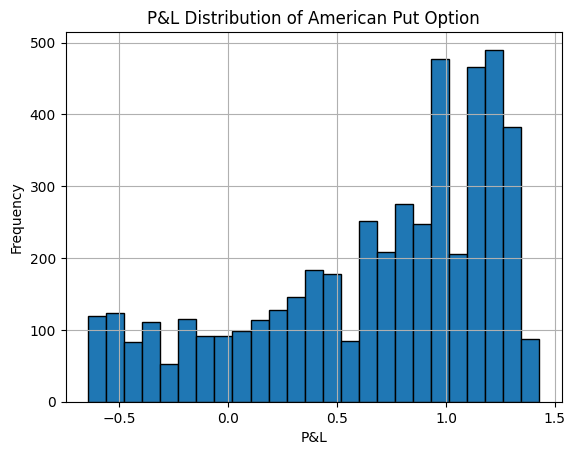

Number of zero-payoff in P&L: 0


In [ ]:
# Input parameters
T = 1  # time to maturity
S0 = 10  # initial stock price
sigma = 0.20  # volatility
r = 0.00  # risk-free rate
N = 5000  # number of time steps
K = 10  # strike price

# Calculate delta t
delta_t = T / N

# Calculate up and down factors
u = np.exp(sigma * np.sqrt(delta_t))
d = 1/u
np.random.seed(63)
q = (1-np.exp(-sigma * np.sqrt(delta_t)))/(np.exp(sigma * np.sqrt(delta_t))-np.exp(-1*sigma * np.sqrt(delta_t)))  # risk-neutral probability of up move
P = 0.5*(1+((mu-r)-0.5*sigma**2)/sigma*np.sqrt(delta_t))
exercise_boundary, boundary_index = exercise_boundary_with_index(stock_tree, option_tree, K, r, q, delta_t, N)
V = option_tree
S = stock_tree
simulate_PnL_stopping_time(S0, N, u, d, P, exercise_boundary, K, V, r, delta_t)

- sigma = 0.2, r = 0.02

Average P&L: 0.7044703443356037
Exercise Probability: 0.5178


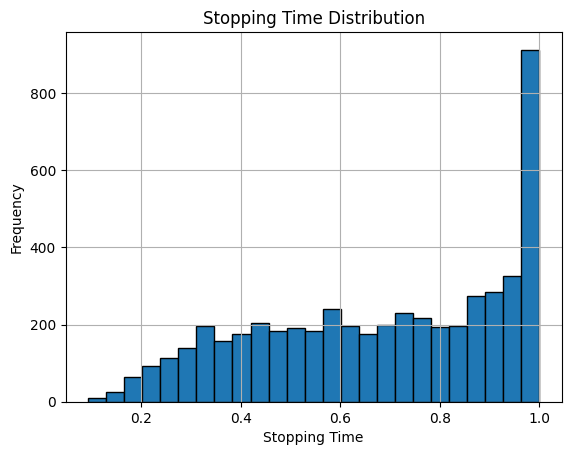

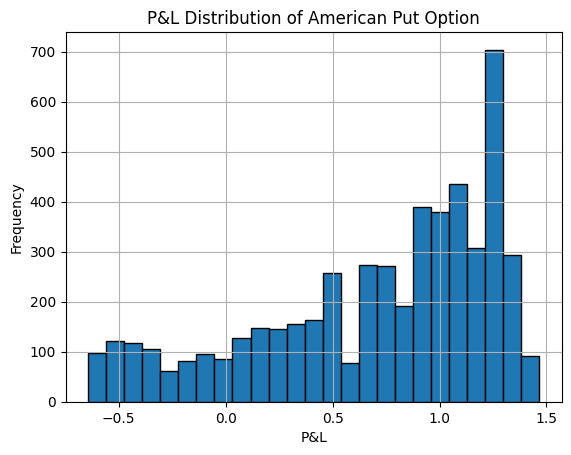

Number of zero-payoff in P&L: 0


In [ ]:
# Input parameters
T = 1  # time to maturity
S0 = 10  # initial stock price
sigma = 0.20  # volatility
r = 0.02  # risk-free rate
N = 5000  # number of time steps
K = 10  # strike price

# Calculate delta t
delta_t = T / N

# Calculate up and down factors
u = np.exp(sigma * np.sqrt(delta_t))
d = 1/u
np.random.seed(63)
q = (1-np.exp(-sigma * np.sqrt(delta_t)))/(np.exp(sigma * np.sqrt(delta_t))-np.exp(-1*sigma * np.sqrt(delta_t)))  # risk-neutral probability of up move
P = 0.5*(1+((mu-r)-0.5*sigma**2)/sigma*np.sqrt(delta_t))
exercise_boundary, boundary_index = exercise_boundary_with_index(stock_tree, option_tree, K, r, q, delta_t, N)
V = option_tree
S = stock_tree
simulate_PnL_stopping_time(S0, N, u, d, P, exercise_boundary, K, V, r, delta_t)

- sigma = 0.2, r = 0.04

Average P&L: 0.7304258023016331
Exercise Probability: 0.5581


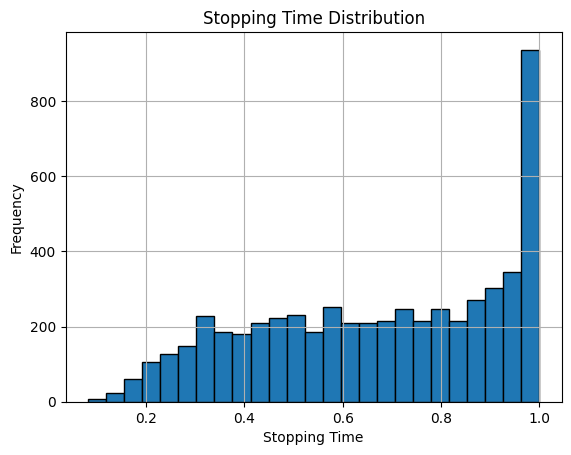

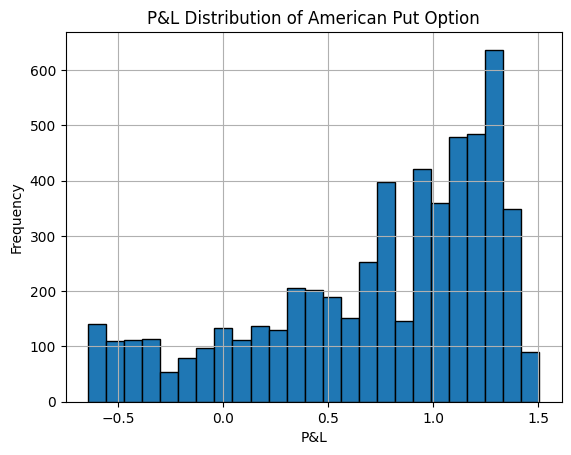

Number of zero-payoff in P&L: 0


In [ ]:
# Input parameters
T = 1  # time to maturity
S0 = 10  # initial stock price
sigma = 0.20  # volatility
r = 0.04  # risk-free rate
N = 5000  # number of time steps
K = 10  # strike price

# Calculate delta t
delta_t = T / N

# Calculate up and down factors
u = np.exp(sigma * np.sqrt(delta_t))
d = 1/u
np.random.seed(63)
q = (1-np.exp(-sigma * np.sqrt(delta_t)))/(np.exp(sigma * np.sqrt(delta_t))-np.exp(-1*sigma * np.sqrt(delta_t)))  # risk-neutral probability of up move
P = 0.5*(1+((mu-r)-0.5*sigma**2)/sigma*np.sqrt(delta_t))
exercise_boundary, boundary_index = exercise_boundary_with_index(stock_tree, option_tree, K, r, q, delta_t, N)
V = option_tree
S = stock_tree
simulate_PnL_stopping_time(S0, N, u, d, P, exercise_boundary, K, V, r, delta_t)

- sigma = 0.3, r = 0.00

Average P&L: 1.0077642920510252
Exercise Probability: 0.5916


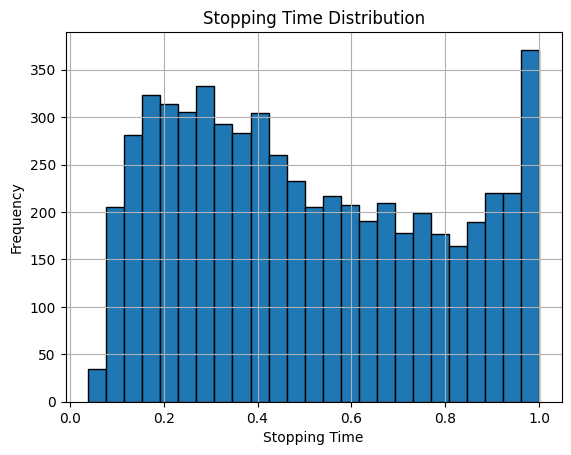

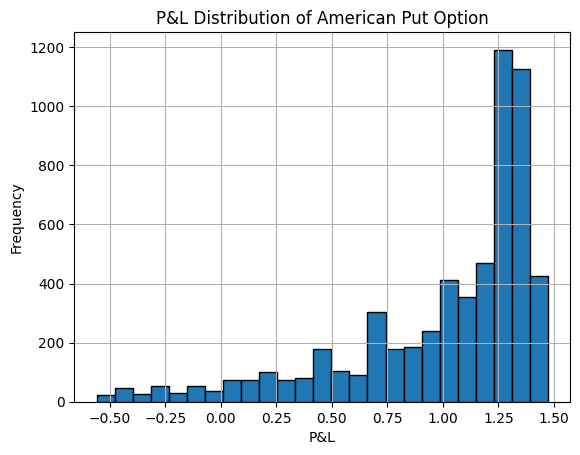

Number of zero-payoff in P&L: 0


In [ ]:
# Input parameters
T = 1  # time to maturity
S0 = 10  # initial stock price
sigma = 0.30  # volatility
r = 0.00  # risk-free rate
N = 5000  # number of time steps
K = 10  # strike price

# Calculate delta t
delta_t = T / N

# Calculate up and down factors
u = np.exp(sigma * np.sqrt(delta_t))
d = 1/u
np.random.seed(63)
q = (1-np.exp(-sigma * np.sqrt(delta_t)))/(np.exp(sigma * np.sqrt(delta_t))-np.exp(-1*sigma * np.sqrt(delta_t)))  # risk-neutral probability of up move
P = 0.5*(1+((mu-r)-0.5*sigma**2)/sigma*np.sqrt(delta_t))
exercise_boundary, boundary_index = exercise_boundary_with_index(stock_tree, option_tree, K, r, q, delta_t, N)
V = option_tree
S = stock_tree
simulate_PnL_stopping_time(S0, N, u, d, P, exercise_boundary, K, V, r, delta_t)

- sigma = 0.3, r = 0.02

Average P&L: 1.0243991182612309
Exercise Probability: 0.6163


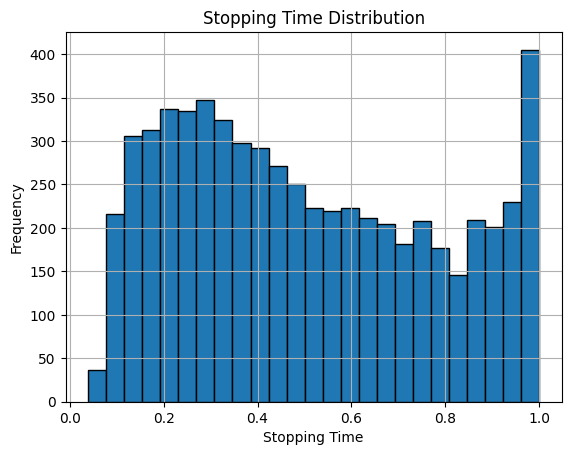

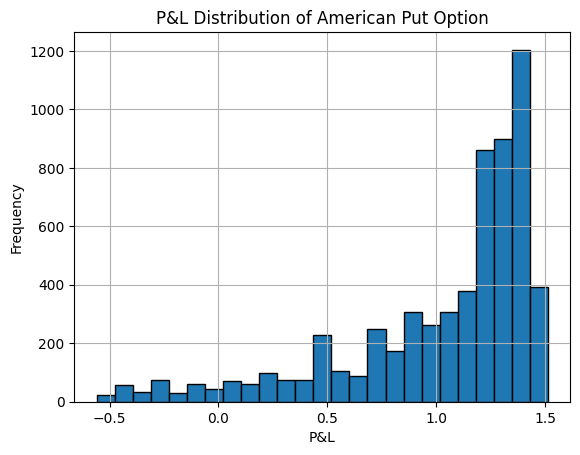

Number of zero-payoff in P&L: 0


In [ ]:
# Input parameters
T = 1  # time to maturity
S0 = 10  # initial stock price
sigma = 0.30  # volatility
r = 0.02  # risk-free rate
N = 5000  # number of time steps
K = 10  # strike price

# Calculate delta t
delta_t = T / N

# Calculate up and down factors
u = np.exp(sigma * np.sqrt(delta_t))
d = 1/u
np.random.seed(63)
q = (1-np.exp(-sigma * np.sqrt(delta_t)))/(np.exp(sigma * np.sqrt(delta_t))-np.exp(-1*sigma * np.sqrt(delta_t)))  # risk-neutral probability of up move
P = 0.5*(1+((mu-r)-0.5*sigma**2)/sigma*np.sqrt(delta_t))
exercise_boundary, boundary_index = exercise_boundary_with_index(stock_tree, option_tree, K, r, q, delta_t, N)
V = option_tree
S = stock_tree
simulate_PnL_stopping_time(S0, N, u, d, P, exercise_boundary, K, V, r, delta_t)

- sigma = 0.3, r = 0.04

Average P&L: 1.0487862451933003
Exercise Probability: 0.6408


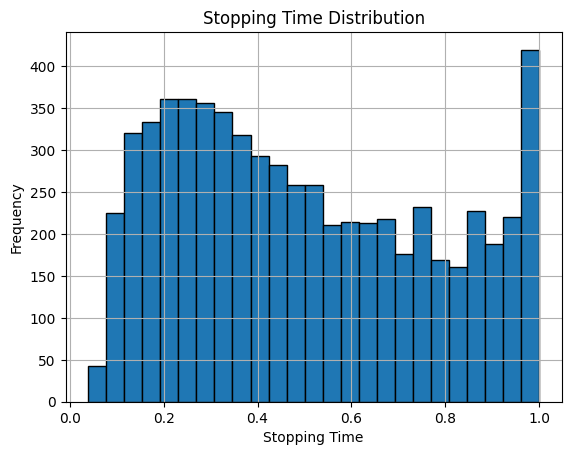

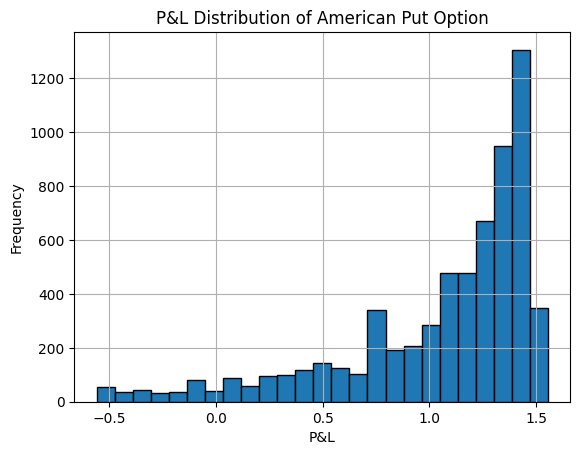

Number of zero-payoff in P&L: 0


In [ ]:
# Input parameters
T = 1  # time to maturity
S0 = 10  # initial stock price
sigma = 0.30  # volatility
r = 0.04  # risk-free rate
N = 5000  # number of time steps
K = 10  # strike price

# Calculate delta t
delta_t = T / N

# Calculate up and down factors
u = np.exp(sigma * np.sqrt(delta_t))
d = 1/u
np.random.seed(63)
q = (1-np.exp(-sigma * np.sqrt(delta_t)))/(np.exp(sigma * np.sqrt(delta_t))-np.exp(-1*sigma * np.sqrt(delta_t)))  # risk-neutral probability of up move
P = 0.5*(1+((mu-r)-0.5*sigma**2)/sigma*np.sqrt(delta_t))
exercise_boundary, boundary_index = exercise_boundary_with_index(stock_tree, option_tree, K, r, q, delta_t, N)
V = option_tree
S = stock_tree
simulate_PnL_stopping_time(S0, N, u, d, P, exercise_boundary, K, V, r, delta_t)

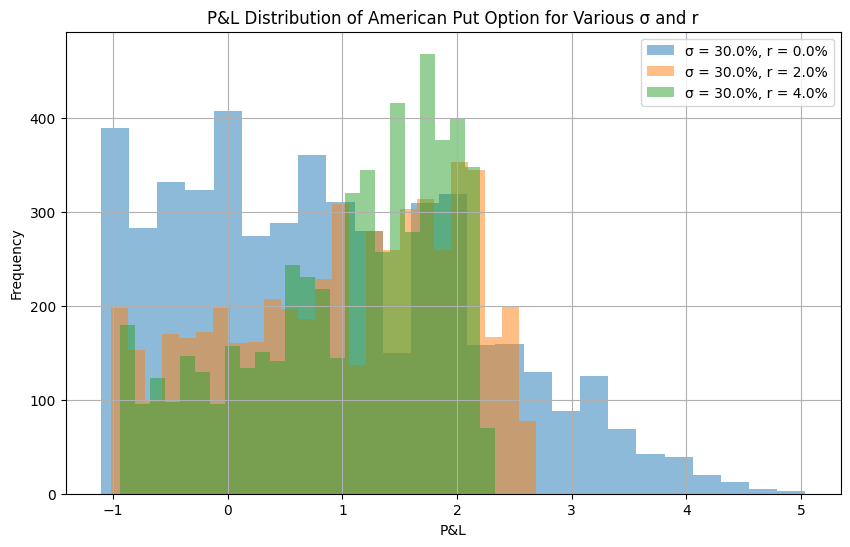

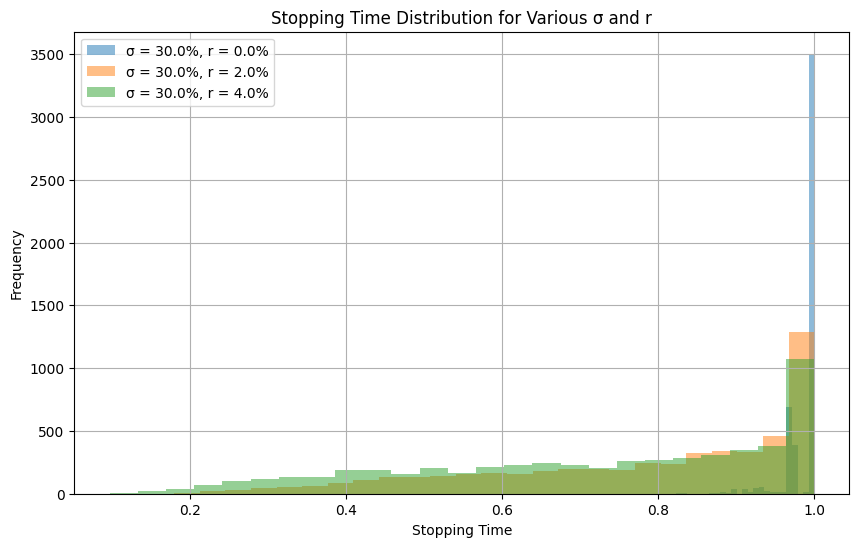

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(63)

# Input parameters
T = 1  # time to maturity
S0 = 10  # initial stock price
K = 10  # strike price
mu = 0.05
N = 5000  # number of time steps
delta_t = T / N

# Initialize the container for the results
all_PL = {}
all_stopping_times = {}

# Define the values of sigma and r
#sigmas = [0.10, 0.20, 0.30]
interest_rates = [0.00, 0.02, 0.04]

# Loop over different sigma and r combinations
#for sigma in sigmas:
for r in interest_rates:
        # Calculate up and down factors
        sigma = 0.3
        u = np.exp(sigma * np.sqrt(delta_t))
        d = 1/u

        # Risk-neutral probability
        q = (1-np.exp(-sigma * np.sqrt(delta_t)))/(np.exp(sigma * np.sqrt(delta_t))-np.exp(-1*sigma * np.sqrt(delta_t)))  # risk-neutral probability of up move


        # Real-world probability
        P = 0.5 * (1 + ((mu - r) - 0.5 * sigma**2) / sigma * np.sqrt(delta_t))
        stock_tree = build_stock_tree(S0, u, d, N)
        option_tree = build_option_tree(stock_tree, K, r, q, delta_t, N)
        exercise_boundary, boundary_index = exercise_boundary_with_index(stock_tree, option_tree, K, r, q, delta_t, N)
        V = option_tree
        S = stock_tree
        simulate_PnL_stopping_time(S0, N, u, d, P, exercise_boundary, K, V, r, delta_t)

        # Simulate P&L and stopping time
        PL, stopping_times = simulate_PnL_stopping_time(S0, N, u, d, P, exercise_boundary, K, V, r, delta_t)

        # Store the results
        all_PL[(sigma, r)] = PL
        all_stopping_times[(sigma, r)] = stopping_times

# Plot all P&L on the same plot
plt.figure(figsize=(10, 6))
for (sigma, r), PL in all_PL.items():
    plt.hist(PL, bins=25, alpha=0.5, label=f'σ = {sigma*100}%, r = {r*100}%')
plt.xlabel('P&L')
plt.ylabel('Frequency')
plt.title('P&L Distribution of American Put Option for Various σ and r')
plt.legend()
plt.grid(True)
plt.show()

# Plot all stopping times on the same plot
plt.figure(figsize=(10, 6))
for (sigma, r), stopping_times in all_stopping_times.items():
    plt.hist(stopping_times, bins=25, alpha=0.5, label=f'σ = {sigma*100}%, r = {r*100}%')
plt.xlabel('Stopping Time')
plt.ylabel('Frequency')
plt.title('Stopping Time Distribution for Various σ and r')
plt.legend()
plt.grid(True)
plt.show()


### iii)

Average P&L: 0.6684087556778775
Exercise Probability: 0.4118


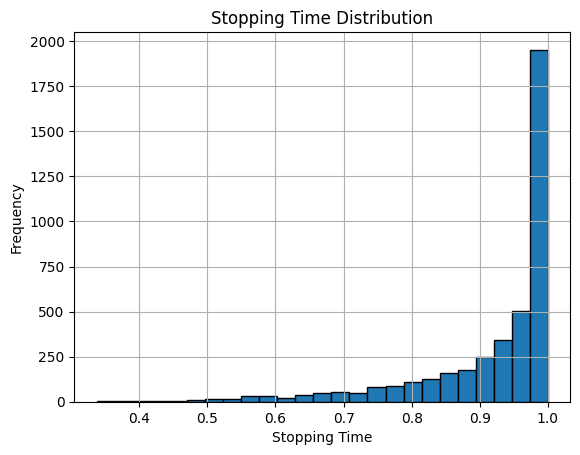

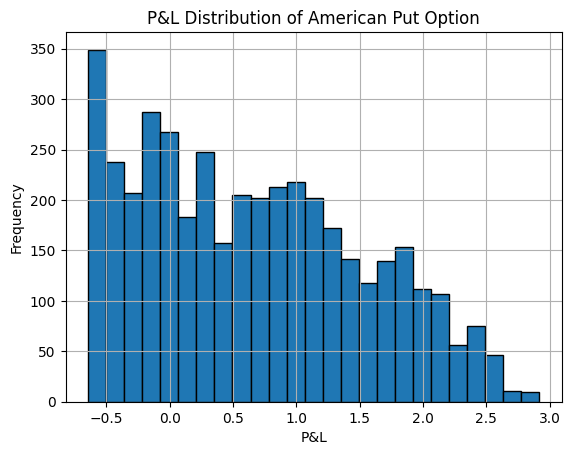

Number of zero-payoff in P&L: 0


In [ ]:

# Input parameters
T = 1  # time to maturity
S0 = 10  # initial stock price
sigma = 0.10  # volatility
r = 0.02  # risk-free rate
N = 5000  # number of time steps
K = 10  # strike price

# Calculate delta t
delta_t = T / N
stock_tree = build_stock_tree(S0,u,d,N)
option_tree = build_option_tree(stock_tree,K,r,q,delta_t,N)
exercise_boundary, boundary_index = exercise_boundary_with_index(stock_tree, option_tree, K, r, q, delta_t, N)
# Calculate up and down factors
sigma1 = 0.1
u = np.exp(sigma * np.sqrt(delta_t))
d = 1/u
np.random.seed(63)
q = (1-np.exp(-sigma * np.sqrt(delta_t)))/(np.exp(sigma * np.sqrt(delta_t))-np.exp(-1*sigma * np.sqrt(delta_t)))  # risk-neutral probability of up move
P = 0.5*(1+((mu-r)-0.5*sigma1**2)/sigma1*np.sqrt(delta_t))
simulate_PnL_stopping_time(S0, N, u, d, P, exercise_boundary, K, V, r, delta_t)

Average P&L: 0.7229649193278578
Exercise Probability: 0.461


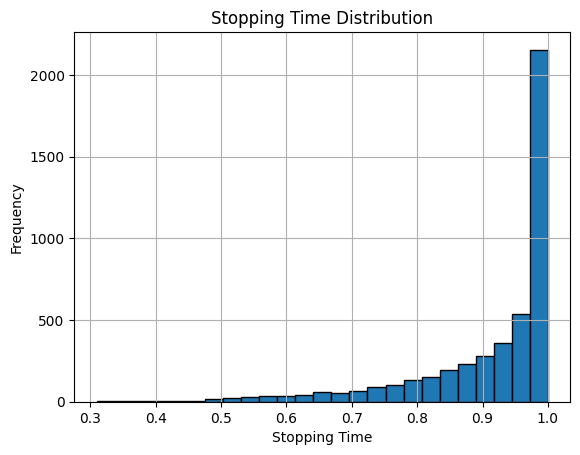

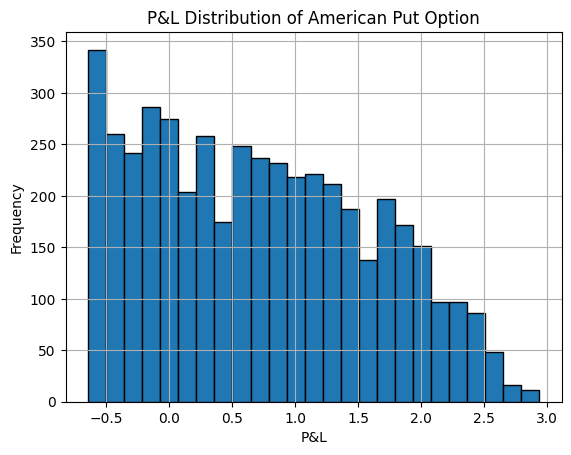

Number of zero-payoff in P&L: 0


In [ ]:
# Calculate up and down factors
sigma1 = 0.15
u = np.exp(sigma * np.sqrt(delta_t))
d = 1/u
np.random.seed(63)
q = (1-np.exp(-sigma * np.sqrt(delta_t)))/(np.exp(sigma * np.sqrt(delta_t))-np.exp(-1*sigma * np.sqrt(delta_t)))  # risk-neutral probability of up move
P = 0.5*(1+((mu-r)-0.5*sigma1**2)/sigma1*np.sqrt(delta_t))
simulate_PnL_stopping_time(S0, N, u, d, P, exercise_boundary, K, V, r, delta_t)

Average P&L: 0.7676833496763652
Exercise Probability: 0.4877


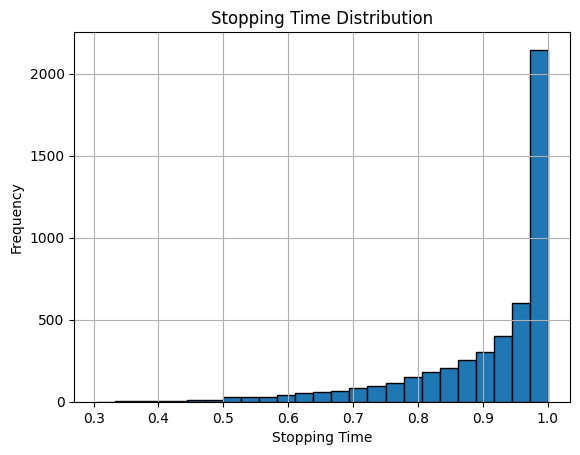

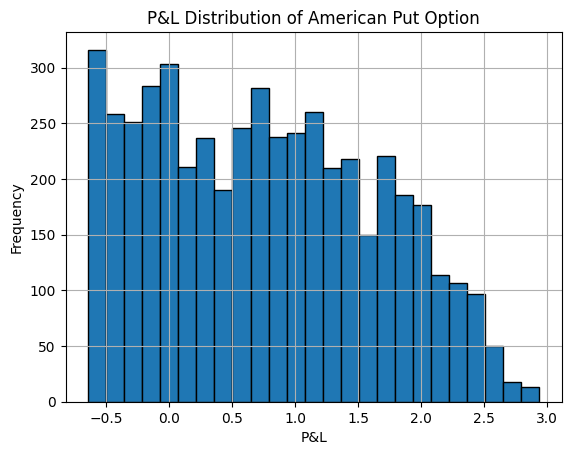

Number of zero-payoff in P&L: 0


In [ ]:
# Calculate up and down factors
sigma1 = 0.2
u = np.exp(sigma * np.sqrt(delta_t))
d = 1/u
np.random.seed(63)
q = (1-np.exp(-sigma * np.sqrt(delta_t)))/(np.exp(sigma * np.sqrt(delta_t))-np.exp(-1*sigma * np.sqrt(delta_t)))  # risk-neutral probability of up move
P = 0.5*(1+((mu-r)-0.5*sigma1**2)/sigma1*np.sqrt(delta_t))
simulate_PnL_stopping_time(S0, N, u, d, P, exercise_boundary, K, V, r, delta_t)

Average P&L: 0.7896456523976279
Exercise Probability: 0.5103


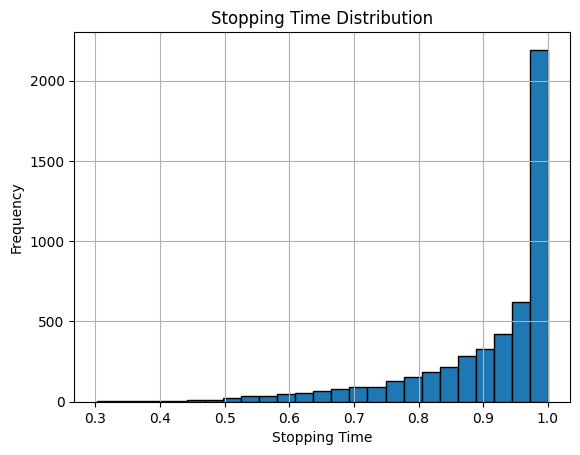

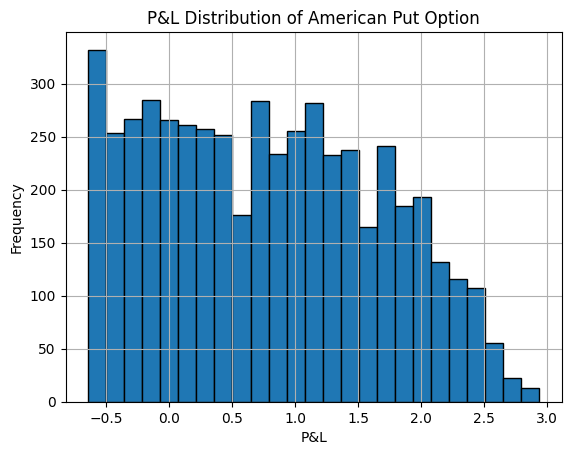

Number of zero-payoff in P&L: 0


In [ ]:
# Calculate up and down factors
sigma1 = 0.25
u = np.exp(sigma * np.sqrt(delta_t))
d = 1/u
np.random.seed(63)
q = (1-np.exp(-sigma * np.sqrt(delta_t)))/(np.exp(sigma * np.sqrt(delta_t))-np.exp(-1*sigma * np.sqrt(delta_t)))  # risk-neutral probability of up move
P = 0.5*(1+((mu-r)-0.5*sigma1**2)/sigma1*np.sqrt(delta_t))
simulate_PnL_stopping_time(S0, N, u, d, P, exercise_boundary, K, V, r, delta_t)

Average P&L: 0.8114986321746573
Exercise Probability: 0.5291


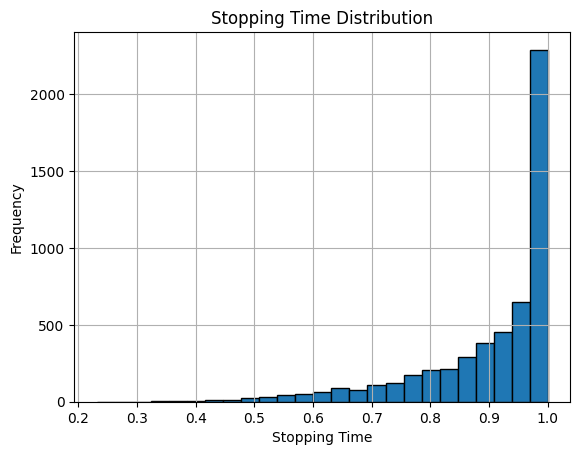

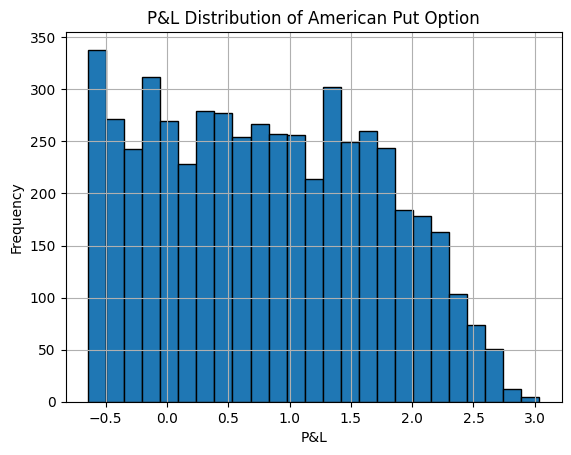

Number of zero-payoff in P&L: 0


In [ ]:
# Calculate up and down factors
sigma1 = 0.3
u = np.exp(sigma * np.sqrt(delta_t))
d = 1/u
np.random.seed(63)
q = (1-np.exp(-sigma * np.sqrt(delta_t)))/(np.exp(sigma * np.sqrt(delta_t))-np.exp(-1*sigma * np.sqrt(delta_t)))  # risk-neutral probability of up move
P = 0.5*(1+((mu-r)-0.5*sigma1**2)/sigma1*np.sqrt(delta_t))
simulate_PnL_stopping_time(S0, N, u, d, P, exercise_boundary, K, V, r, delta_t)

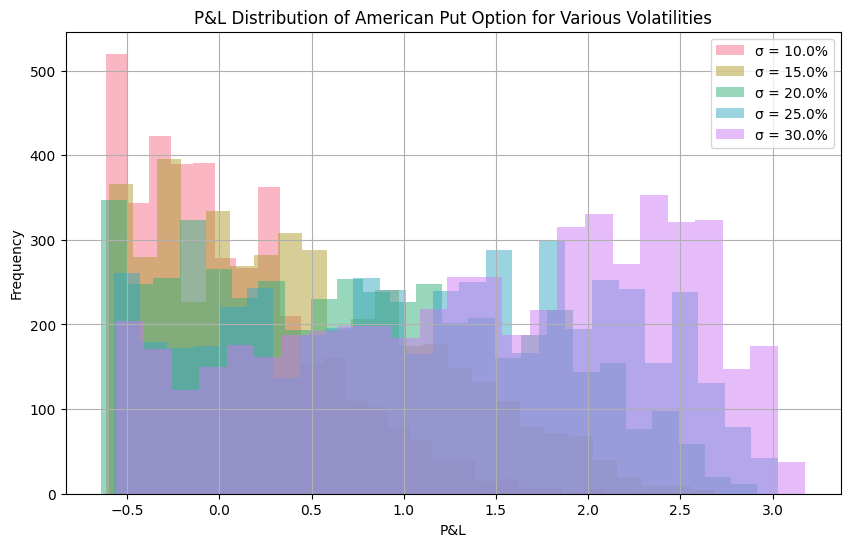

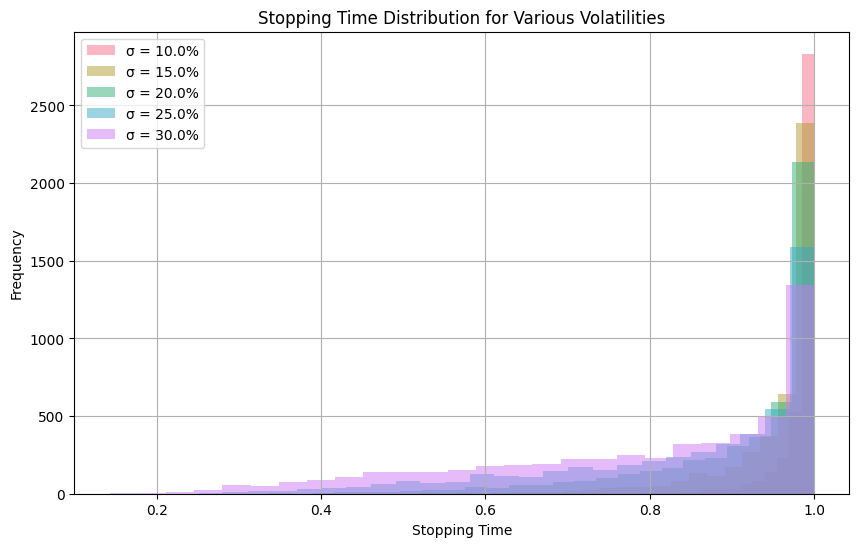

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
np.random.seed(63)

# Run simulations for different realized volatilities
realized_volatilities = [0.10, 0.15, 0.20, 0.25, 0.30]

all_PL = {}
all_stopping_times = {}

for sigma_realized in realized_volatilities:
    # Calculate up and down factors for the realized sigma
    u_realized = np.exp(sigma_realized * np.sqrt(delta_t))
    d_realized = 1/u_realized

    # Real-world probability (adjust based on volatility)
    P_realized = 0.5 * (1 + ((mu - r) - 0.5 * sigma_realized**2) / sigma_realized * np.sqrt(delta_t))

    # Simulate P&L and stopping time for each realized volatility
    PL, stopping_times = simulate_PnL_stopping_time(S0, N, u_realized, d_realized, P_realized, exercise_boundary, K, V, r, delta_t, sigma_realized)

    # Store the results
    all_PL[sigma_realized] = PL
    all_stopping_times[sigma_realized] = stopping_times
colors = sns.color_palette("husl", len(realized_volatilities))

# Plot all P&L on the same plot
plt.figure(figsize=(10, 6))
for idx, (sigma_realized, PL) in enumerate(all_PL.items()):
    plt.hist(PL, bins=25, alpha=0.5, color=colors[idx], label=f'σ = {sigma_realized*100}%')
plt.xlabel('P&L')
plt.ylabel('Frequency')
plt.title('P&L Distribution of American Put Option for Various Volatilities')
plt.legend()
plt.grid(True)
plt.show()

# Plot all stopping times on the same plot
plt.figure(figsize=(10, 6))
for idx, (sigma_realized, stopping_times) in enumerate(all_stopping_times.items()):
    plt.hist(stopping_times, bins=25, alpha=0.5, color=colors[idx], label=f'σ = {sigma_realized*100}%')
plt.xlabel('Stopping Time')
plt.ylabel('Frequency')
plt.title('Stopping Time Distribution for Various Volatilities')
plt.legend()
plt.grid(True)
plt.show()